# Configuration

In [1]:
import os
from tqdm.notebook import tqdm
from tqdm import tqdm
import librosa
import pandas as pd 
import pandas as np
from sklearn.metrics import classification_report

# Clean Data - Compute dataframes for datasets and split in Train, Val, Test 

In [2]:
main_path = '/Users/helemanc/Documents/MasterAI/THESIS/Datasets SER'
TESS = os.path.join(main_path, "tess/TESS Toronto emotional speech set data/") 
RAV = os.path.join(main_path, "ravdess-emotional-speech-audio/audio_speech_actors_01-24")
SAVEE = os.path.join(main_path, "savee/ALL/")
CREMA = os.path.join(main_path, "creamd/AudioWAV/")

## RAVDESS

In [3]:
lst = []
emotion = []
voc_channel = []
full_path = []
modality = []
intensity = []
actors = []
phrase =[]

for root, dirs, files in tqdm(os.walk(RAV)):
    for file in files:
        try:
            #Load librosa array, obtain mfcss, store the file and the mfcss information in a new array
            # X, sample_rate = librosa.load(os.path.join(root,file), res_type='kaiser_fast')
            # mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
           
            modal = int(file[1:2])
            vchan = int(file[4:5])
            lab = int(file[7:8])
            ints = int(file[10:11])
            phr = int(file[13:14])
            act = int(file[18:20])
            # arr = mfccs, lab
            # lst.append(arr)
            
            modality.append(modal)
            voc_channel.append(vchan)
            emotion.append(lab) #only labels
            intensity.append(ints)
            phrase.append(phr)
            actors.append(act)
            
            full_path.append((root, file)) # only files
          # If the file is not valid, skip it
        except ValueError:
            continue

25it [00:00, 305.64it/s]


In [4]:
# 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
# merge neutral and calm
emotions_list = ['neutral', 'neutral', 'happy', 'sadness', 'angry', 'fear', 'disgust', 'surprise']
emotion_dict = {em[0]+1:em[1] for em in enumerate(emotions_list)}

df = pd.DataFrame([emotion, voc_channel, modality, intensity, actors, actors,phrase, full_path]).T
df.columns = ['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'gender', 'phrase', 'path']
df['emotion'] = df['emotion'].map(emotion_dict)
df['voc_channel'] = df['voc_channel'].map({1: 'speech', 2:'song'})
df['modality'] = df['modality'].map({1: 'full AV', 2:'video only', 3:'audio only'})
df['intensity'] = df['intensity'].map({1: 'normal', 2:'strong'})
df['actors'] = df['actors']
df['gender'] = df['actors'].apply(lambda x: 'female' if x%2 == 0 else 'male')
df['phrase'] = df['phrase'].map({1: 'Kids are talking by the door', 2:'Dogs are sitting by the door'})
df['path'] = df['path'].apply(lambda x: x[0] + '/' + x[1])

In [5]:
# remove files with noise to apply the same noise to all files for data augmentation 
df = df[~df.path.str.contains('noise')]

In [6]:
df.head()

,emotion,voc_channel,modality,intensity,actors,gender,phrase,path
0,angry,speech,audio only,normal,16,female,Dogs are sitting by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,fear,speech,audio only,normal,16,female,Dogs are sitting by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,fear,speech,audio only,strong,16,female,Kids are talking by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,angry,speech,audio only,strong,16,female,Kids are talking by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
5,disgust,speech,audio only,normal,16,female,Kids are talking by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [7]:
# only speech
RAV_df = df
RAV_df = RAV_df.loc[RAV_df.voc_channel == 'speech']

In [8]:
RAV_df.insert(0, "emotion_label", RAV_df.emotion, True)

In [9]:
RAV_df = RAV_df.drop(['emotion', 'voc_channel', 'modality', 'intensity', 'phrase'], 1)

In [10]:
RAV_df

,emotion_label,actors,gender,path
0,angry,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,fear,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,fear,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,angry,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
5,disgust,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
...,...,...,...,...
2869,happy,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2871,happy,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2872,neutral,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2873,neutral,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [11]:
RAV_train = []
RAV_val = []
RAV_test = []

In [12]:
for index, row in RAV_df.iterrows():
    if row['actors'] in range(1,21): 
        RAV_train.append(row) 
    elif row['actors'] in range(21,23): 
        RAV_val.append(row)
    elif row['actors'] in range(23,25): 
        RAV_test.append(row)
len(RAV_train), len(RAV_val), len(RAV_test)

(1200, 120, 120)

In [13]:
RAV_train = pd.DataFrame(RAV_train)
RAV_val = pd.DataFrame(RAV_val)
RAV_test = pd.DataFrame(RAV_test)

In [14]:
RAV_train = RAV_train.drop(['actors'], 1)
RAV_val = RAV_val.drop(['actors'], 1)
RAV_test = RAV_test.drop(['actors'], 1)

In [15]:
RAV_train.reset_index(drop=True, inplace = True) 
RAV_val.reset_index(drop=True, inplace = True) 
RAV_test.reset_index(drop=True, inplace = True ) 

## SAVEE

In [16]:
# Get the data location for SAVEE
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions
emotion=[]
path = []
actors = []
gender = []
for i in dir_list:
    actors.append(i[:2])
    if i[-8:-6]=='_a':
        emotion.append('angry')
        gender.append('male')
    elif i[-8:-6]=='_d':
        emotion.append('disgust')
        gender.append('male')
    elif i[-8:-6]=='_f':
        emotion.append('fear')
        gender.append('male')
    elif i[-8:-6]=='_h':
        emotion.append('happy')
        gender.append('male')
    elif i[-8:-6]=='_n':
        emotion.append('neutral')
        gender.append('male')
    elif i[-8:-6]=='sa':
        emotion.append('sadness')
        gender.append('male')
    elif i[-8:-6]=='su':
        emotion.append('surprise')
        gender.append('male') 
    else:
        emotion.append('Unknown') 
    path.append(SAVEE + i)
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['emotion_label'])
                      
SAVEE_df = pd.concat([SAVEE_df,
                      pd.DataFrame(actors, columns = ['actors']),
                      pd.DataFrame(gender, columns = ['gender']), 
                      pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.emotion_label.value_counts()

neutral     120
sadness      60
happy        60
fear         60
surprise     60
angry        60
disgust      60
Name: emotion_label, dtype: int64

In [17]:
SAVEE_df.head()

,emotion_label,actors,gender,path
0,sadness,JK,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,sadness,JK,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,neutral,DC,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,surprise,DC,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
4,neutral,DC,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [18]:
SAVEE_train = []
SAVEE_val = []
SAVEE_test = []

In [19]:
#DC, JE, JK, KL
for index, row in SAVEE_df.iterrows(): 
    if row['actors'] == 'DC' or row ['actors'] == 'JE':
        SAVEE_train.append(row)
    elif row['actors'] == 'JK': 
        SAVEE_val.append(row)
    else: 
        SAVEE_test.append(row)
len(SAVEE_train), len(SAVEE_val), len(SAVEE_test)

(240, 120, 120)

In [20]:
SAVEE_train = pd.DataFrame(SAVEE_train)
SAVEE_val = pd.DataFrame(SAVEE_val)
SAVEE_test = pd.DataFrame(SAVEE_test)

In [21]:
SAVEE_train = SAVEE_train.drop(['actors'], 1)
SAVEE_val = SAVEE_val.drop(['actors'], 1)
SAVEE_test = SAVEE_test.drop(['actors'], 1)

In [22]:
SAVEE_train = SAVEE_train.reset_index(drop=True) 
SAVEE_val = SAVEE_val.reset_index(drop=True) 
SAVEE_test = SAVEE_test.reset_index(drop=True) 

## TESS

In [23]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

path = []
emotion = []
gender = []
actors = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry':
            emotion.append('angry')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_angry': 
            emotion.append('angry')
            gender.append('female')
            actors.append('YAF')
            
            
        elif i == 'OAF_disgust' :
            emotion.append('disgust')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_disgust': 
            emotion.append('disgust')
            gender.append('female')
            actors.append('YAF')
            
            
        elif i == 'OAF_Fear':
            emotion.append('fear')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_fear': 
            emotion.append('fear')
            gender.append('female')
            actors.append('YAF') 
            
            
        elif i == 'OAF_happy' :
            emotion.append('happy')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_happy': 
            emotion.append('angry')
            gender.append('female')
            actors.append('YAF')            
            
        elif i == 'OAF_neutral':
            emotion.append('neutral')
            gender.append('female')
            actors.append('OAF')   
        elif i == 'YAF_neutral': 
            emotion.append('neutral')
            gender.append('female')
            actors.append('YAF')      
            
                
        elif i == 'OAF_Pleasant_surprise':
            emotion.append('surprise')
            gender.append('female')
            actors.append('OAF')
        
        elif i == 'YAF_pleasant_surprised': 
            emotion.append('surprise')
            gender.append('female')
            actors.append('YAF')            
            
        elif i == 'OAF_Sad':
            emotion.append('sadness')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_sad': 
            emotion.append('sadness')
            gender.append('female')
            actors.append('YAF')            
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['emotion_label'])
TESS_df = pd.concat([TESS_df, pd.DataFrame(gender, columns = ['gender']), 
                     pd.DataFrame(actors, columns= ['actors']),
                     pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.emotion_label.value_counts()

angry       1200
surprise     800
fear         800
neutral      800
sadness      800
disgust      800
happy        400
Name: emotion_label, dtype: int64

In [24]:
TESS_df= TESS_df[~TESS_df.path.str.contains('noise')]

In [25]:
TESS_train = []
TESS_test = []

In [26]:
for index, row in TESS_df.iterrows(): 
    if row['actors'] == 'YAF': 
        TESS_train.append(row)
    else: 
        TESS_test.append(row)
len(TESS_train), len(TESS_test)

(1400, 1400)

In [27]:
TESS_train = pd.DataFrame(TESS_train)
TESS_test = pd.DataFrame(TESS_test)

In [28]:
TESS_train = TESS_train.drop(['actors'], 1)
TESS_test = TESS_test.drop(['actors'], 1)

In [29]:
TESS_train = TESS_train.reset_index(drop=True) 
TESS_test  = TESS_test.reset_index(drop=True) 

## CREMA-D

In [30]:
males = [1,
5,
11,
14,
15,
16,
17,
19,
22,
23,
26,
27,
31,
32,
33,
34,
35,
36,
38,
39,
41,
42,
44,
45,
48,
50,
51,
57,
59, 
62, 
64,
65, 
66,
67,
68,
69,
70,
71,
77, 
80, 
81, 
83, 
85, 
86, 
87,
88, 
90]

In [31]:
females = [ 2,
3,
4,
6,
7,
8,
9,
10,
12,
13,
18,
20,
21,
24,
25,
28,
29,
30,
37,
40,
43,
46,
47,
49,
52,
53,
54,
55,
56, 
58, 
60,
61,
63,
72, 
73, 
74, 
75, 
76, 
78, 
79, 
82, 
84, 
89, 
91]

In [32]:
crema_directory_list = os.listdir(CREMA)

file_emotion = []
file_path = []
actors = []
gender = []




for file in crema_directory_list:

    # storing file emotions
    part=file.split('_')
    
    # use only high intensity files
    if "HI" in part[3] :
        actor = part[0][2:]
        actors.append(actor)
        if int(actor) in males:
            gender.append('male')
        else: 
            gender.append('female')
    
        # storing file paths
        file_path.append(CREMA + file)
        if part[2] == 'SAD':
            file_emotion.append('sadness')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['emotion_label'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['path'])
actors_df = pd.DataFrame(actors, columns=['actors'])
gender_df = pd.DataFrame(gender, columns=['gender'])                      
Crema_df = pd.concat([emotion_df, actors_df, gender_df, path_df], axis=1)
Crema_df.head()

,emotion_label,actors,gender,path
0,sadness,28,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,angry,48,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,disgust,27,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,disgust,32,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
4,happy,80,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [33]:
Crema_df.shape

(455, 4)

In [34]:
actor_files = {}

for index, row in Crema_df.iterrows():
    actor = row['actors']
    if actor not in actor_files.keys(): 
        actor_files[actor] = 1
    else: 
        actor_files[actor]+=1

In [35]:
actor_files

{'28': 5,
 '48': 5,
 '27': 5,
 '32': 5,
 '80': 5,
 '59': 5,
 '39': 5,
 '43': 5,
 '56': 5,
 '31': 5,
 '24': 5,
 '51': 5,
 '44': 5,
 '77': 5,
 '62': 5,
 '88': 5,
 '55': 5,
 '40': 5,
 '13': 5,
 '06': 5,
 '35': 5,
 '20': 5,
 '87': 5,
 '09': 5,
 '78': 5,
 '65': 5,
 '70': 5,
 '23': 5,
 '36': 5,
 '01': 5,
 '14': 5,
 '47': 5,
 '52': 5,
 '58': 5,
 '37': 5,
 '22': 5,
 '71': 5,
 '64': 5,
 '50': 5,
 '45': 5,
 '57': 5,
 '42': 5,
 '29': 5,
 '53': 5,
 '46': 5,
 '33': 5,
 '26': 5,
 '34': 5,
 '21': 5,
 '15': 5,
 '08': 5,
 '86': 5,
 '79': 5,
 '63': 5,
 '76': 5,
 '25': 5,
 '30': 5,
 '07': 5,
 '12': 5,
 '41': 5,
 '54': 5,
 '89': 5,
 '81': 5,
 '49': 5,
 '38': 5,
 '05': 5,
 '10': 5,
 '61': 5,
 '74': 5,
 '69': 5,
 '18': 5,
 '83': 5,
 '17': 5,
 '02': 5,
 '73': 5,
 '66': 5,
 '84': 5,
 '91': 5,
 '90': 5,
 '85': 5,
 '03': 5,
 '16': 5,
 '67': 5,
 '72': 5,
 '68': 5,
 '82': 5,
 '19': 5,
 '11': 5,
 '04': 5,
 '75': 5,
 '60': 5}

In [36]:
count_males = 0 
count_females = 0 
male_list = []
for index, row in Crema_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if gender == 'male':
        count_males +=1
        if actor not in male_list: 
            male_list.append(actor)
    else: 
        count_females +=1

In [37]:
count_males, count_females

(235, 220)

Since there are more males than females we will remove randomly 3 male actors (since there are exactly 5 audio files per actor)

In [38]:
import random 
'''
random.seed(42)
males_to_remove = random.sample(male_list, 3)
males_to_remove
'''
males_to_remove = ['17', '80', '88']

In [39]:
new_df = []
for index, row in Crema_df.iterrows(): 
    if row['actors'] not in males_to_remove: 
        new_df.append(row)

In [40]:
CREMA_df = pd.DataFrame(new_df)

In [41]:
for index, row in CREMA_df.iterrows(): 
    if row['actors'] == '17': 
        print("Elements not removed")

In [42]:
count_males = 0 
count_females = 0 
male_list = []
female_list = []
for index, row in CREMA_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if gender == 'male':
        count_males +=1
        if actor not in male_list: 
            male_list.append(actor)
    else: 
        count_females +=1
        if actor not in female_list: 
            female_list.append(actor)

In [43]:
count_males, count_females

(220, 220)

In [44]:
len(female_list)

44

In [45]:
len(male_list)

44

In [46]:
CREMA_train = []
CREMA_val = []
CREMA_test = []

In [47]:
females_train = random.sample(female_list, 32)
males_train = random.sample(male_list, 32)

# remove the elements assigned to train 
for element in females_train:
    if element in female_list:
        female_list.remove(element)
        
for element in males_train:
    if element in male_list:
        male_list.remove(element)

         
females_val = random.sample(female_list, 6) 
males_val = random.sample(male_list, 6) 

# remove the elements assigned to val
for element in females_val:
    if element in female_list:
        female_list.remove(element)
        
for element in males_val:
    if element in male_list:
        male_list.remove(element)
        
females_test = random.sample(female_list, 6) 
males_test = random.sample(male_list, 6)        

In [48]:
females_train, males_train, females_val, males_val, females_test, males_test

(['13',
  '37',
  '54',
  '82',
  '29',
  '43',
  '25',
  '30',
  '21',
  '63',
  '84',
  '04',
  '12',
  '06',
  '09',
  '52',
  '79',
  '73',
  '60',
  '08',
  '28',
  '56',
  '07',
  '40',
  '47',
  '91',
  '24',
  '18',
  '72',
  '74',
  '20',
  '49'],
 ['16',
  '31',
  '87',
  '42',
  '51',
  '68',
  '01',
  '62',
  '05',
  '26',
  '35',
  '50',
  '65',
  '22',
  '90',
  '64',
  '27',
  '39',
  '77',
  '69',
  '32',
  '36',
  '33',
  '83',
  '59',
  '66',
  '23',
  '15',
  '70',
  '57',
  '44',
  '86'],
 ['78', '53', '02', '03', '75', '55'],
 ['67', '81', '85', '48', '11', '71'],
 ['76', '46', '89', '61', '58', '10'],
 ['34', '45', '38', '19', '41', '14'])

In [49]:
train = females_train + males_train 
val = females_val + males_val 
test = females_test + males_test

In [50]:
for index, row in CREMA_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if actor in train: 
        CREMA_train.append(row)
    elif actor in val: 
        CREMA_val.append(row)
    else:
        CREMA_test.append(row)

In [51]:
CREMA_train = pd.DataFrame(CREMA_train) 
CREMA_val = pd.DataFrame(CREMA_val) 
CREMA_test = pd.DataFrame(CREMA_test)

In [52]:
CREMA_train.shape, CREMA_val.shape, CREMA_test.shape

((320, 4), (60, 4), (60, 4))

In [53]:
CREMA_train = CREMA_train.drop(['actors'], 1)
CREMA_val = CREMA_val.drop(['actors'], 1)
CREMA_test = CREMA_test.drop(['actors'], 1)

In [54]:
CREMA_train = CREMA_train.reset_index(drop=True) 
CREMA_val = CREMA_val.reset_index(drop = True) 
CREMA_test = CREMA_test.reset_index(drop = True)

# Utils Validation Ensemble

In [55]:
# import main
from inaSpeechSegmenter import Segmenter
from argparse import ArgumentParser
import utils
import warnings

In [56]:
# import utils
from speech_emotion_recognition import feature_extraction as fe, ensemble
import scipy
import numpy as np
from scipy import signal
from scipy.io.wavfile import write
from utils import resample, denoise

In [57]:
# other imports 
import sklearn
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [58]:
#!pip install scikit-learn==0.24.2

In [59]:
#!jupyter nbextension enable --py widgetsnbextension

In [60]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [61]:
def make_predictions(dataset, labels, prediction_scheme): 
    predictions = []
    model_predictions_list = []
    counter = 0
    for filepath in tqdm(dataset['path']):
        samples, sample_rate = fe.read_file(filepath)
        samples, sample_rate = resample(samples, sample_rate)
        new_samples = fe.cut_pad(samples)
        #new_filepath = "tmp.wav"
        final_prediction, model_predictions = ensemble.ensemble(new_samples, prediction_scheme, return_model_predictions = True)

        predictions.append(final_prediction)
        model_predictions_list.append(model_predictions) 
        print("True label", labels[counter], "Predicted label", predictions[counter])
        counter+=1
    return predictions, model_predictions_list

def create_dataframe_prediction_per_model(model_predictions_list):
    df_model_predictions = pd.DataFrame(model_predictions_list)
    df_model_predictions = df_model_predictions.reindex(sorted(df_model_predictions.columns), axis=1)
    return df_model_predictions
    
def create_dataframe_predictions(prediction_list):
    df_predictions = pd.DataFrame(prediction_list)
    return df_predictions

def create_dataframe_res(labels, df_predictions, df_model_predictions, dataset): 
    df_res = pd.concat([labels, 
                    df_predictions, 
                    df_model_predictions, 
                    dataset.path], axis = 1, ignore_index=True, sort=False)
    header_model_predictions = list(df_model_predictions.columns)
    new_header = []
    new_header.append('true_label')
    new_header.append('pred_label')
    new_header = new_header + header_model_predictions
    new_header.append('path')
    df_res.columns = new_header
    return df_res
    
def create_dataframes_false_positives_false_negatives(df_res): 
    misclassified_rows_false_positives = []
    misclassified_rows_false_negatives = []
    for index, row in df_res.iterrows():
        true = df_res.true_label[index]
        pred = df_res.pred_label[index]
        if true != pred: # store misclassified files
            if true ==1 and pred == 0: # disruptive classified as non-distruptive is false negative
                misclassified_rows_false_negatives.append(row)
            else:
                misclassified_rows_false_positives.append(row)  
    df_false_negatives = pd.DataFrame(misclassified_rows_false_negatives)
    df_false_negatives.reset_index(drop=True, inplace=True)

    df_false_positives = pd.DataFrame(misclassified_rows_false_positives)
    df_false_positives.reset_index(drop=True, inplace=True)
    
    return df_false_positives, df_false_negatives

def print_hist_models_predictions_fp(df_false_positives): 
    
    if df_false_positives.empty:
        print('DataFrame False Positives is empty!')
        return 0
    df_models_fp = df_false_positives.copy()
    df_models_fp.drop(columns=['true_label', 'pred_label', 'path'])
    df_models_fp.hist(figsize=(24,24))
    
def print_hist_models_predictions_fn(df_false_negatives): 
    if df_false_negatives.empty:
        print('DataFrame False Negatives is empty!')
        return 0
    df_models_fn = df_false_negatives.copy()
    df_models_fn.drop(columns=['true_label', 'pred_label', 'path'])
    df_models_fn.hist(figsize=(24,24))

# Validation  - RAVDESS

We use the same code of the main.py of the real application, without VAD module

In [62]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'calm':0,  'happy':0, 'sadness':1, 'surprise':0, 'angry':1}
labels= pd.Series(list(RAV_test.emotion_label)).replace(emotion_enc)

In [63]:
predictions, model_prediction_list = make_predictions(RAV_test, labels, prediction_scheme='avg_1')

  1%|          | 1/120 [00:12<25:02, 12.63s/it]

[0.99864733, 0.9609657, 0.80982685, 0.99956155, 0.9680547, 0.98812973, 0.6062024, 0.99212134, 0.99923515, 0.93658036, 0.99987864, 0.9678956, 0.49413493, 0.9985265, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  2%|▏         | 2/120 [00:21<22:46, 11.58s/it]

[0.99059576, 0.6220523, 0.62260556, 0.8400034, 0.638674, 0.8566687, 0.8513299, 0.8371728, 0.9886911, 0.94978154, 0.9980519, 0.85458636, 0.46407506, 0.9769869, 0, 0, 0, 0, 0]
True label 1 Predicted label 0


  2%|▎         | 3/120 [00:31<21:33, 11.05s/it]

[0.53715146, 0.47279242, 0.5428347, 0.4445667, 0.548069, 0.5220484, 0.47014916, 0.35243845, 0.41991892, 0.8277079, 0.6627471, 0.29383564, 0.47792146, 0.7882942, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  3%|▎         | 4/120 [00:42<21:30, 11.12s/it]

[0.9321704, 0.8312286, 0.78808177, 0.8246412, 0.887237, 0.84916615, 0.90694, 0.9782812, 0.98352516, 0.86612165, 0.98488325, 0.8308966, 0.47085267, 0.9866523, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


  4%|▍         | 5/120 [00:52<20:22, 10.63s/it]

[0.9935558, 0.84432775, 0.6000461, 0.94424415, 0.5980262, 0.9784219, 0.42825705, 0.9984257, 0.98181903, 0.84183884, 0.994733, 0.6487325, 0.4526406, 0.6734678, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  5%|▌         | 6/120 [01:03<20:31, 10.80s/it]

[0.95904136, 0.46673268, 0.67485213, 0.9477556, 0.5925212, 0.95203096, 0.79150057, 0.9254403, 0.9870548, 0.96278274, 0.9278852, 0.6374972, 0.49209067, 0.89982146, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  6%|▌         | 7/120 [01:13<19:52, 10.55s/it]

[0.24878111, 0.21907502, 0.4669059, 0.5043085, 0.27471355, 0.41658625, 0.45489413, 0.31555516, 0.41401565, 0.66524327, 0.52808356, 0.090865046, 0.47065854, 0.38217825, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  7%|▋         | 8/120 [01:23<19:35, 10.49s/it]

[0.9269745, 0.242491, 0.45362827, 0.7900915, 0.32889628, 0.39375785, 0.32642478, 0.3535679, 0.28878027, 0.8331104, 0.7297157, 0.098056376, 0.48212066, 0.5964075, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  8%|▊         | 9/120 [01:33<19:12, 10.38s/it]

[0.04610747, 0.0549089, 0.2665887, 0.049016, 0.13914344, 0.009115487, 0.2820657, 0.0013157725, 0.0049009025, 0.70607775, 0.0011411309, 0.04950869, 0.44311172, 0.021656841, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  8%|▊         | 10/120 [01:43<18:23, 10.03s/it]

[0.010546058, 0.1237106, 0.25036433, 0.030788451, 0.2359885, 0.006817937, 0.05240962, 0.011006743, 0.0018426478, 0.8364208, 6.2660445e-05, 0.11329162, 0.47568566, 0.07793629, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  9%|▉         | 11/120 [01:52<17:47,  9.79s/it]

[0.0011739135, 0.004464984, 0.16566947, 0.048639357, 0.03518316, 0.006575376, 0.3460434, 0.00071027875, 0.05375427, 0.9133505, 0.022709817, 0.0015159249, 0.49218374, 0.01750189, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 10%|█         | 12/120 [02:01<17:24,  9.67s/it]

[0.10829425, 0.03270799, 0.17829803, 0.2219306, 0.0962469, 0.070546, 0.015938312, 0.015075922, 0.017677635, 0.5561553, 0.08835387, 0.0035654604, 0.5304917, 0.14726883, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 11%|█         | 13/120 [02:11<17:16,  9.68s/it]

[0.055914223, 0.03275451, 0.3389274, 0.18581033, 0.13176447, 0.11973235, 0.5429561, 0.018871635, 0.47353318, 0.8636409, 0.25662032, 0.21492893, 0.47021475, 0.33204997, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 12%|█▏        | 14/120 [02:20<16:54,  9.57s/it]

[0.3920228, 0.25300497, 0.39708045, 0.24691388, 0.37165636, 0.52999187, 0.22990316, 0.10126838, 0.29797137, 0.70394135, 0.47642565, 0.34058842, 0.53740126, 0.34777123, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 12%|█▎        | 15/120 [02:30<16:33,  9.46s/it]

[0.26113284, 0.17552966, 0.24547216, 0.18923345, 0.24083522, 0.13550454, 0.26803094, 0.48957276, 0.018630058, 0.9428339, 0.0040890872, 0.054029226, 0.46473542, 0.21494365, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 13%|█▎        | 16/120 [02:38<16:06,  9.29s/it]

[0.019020438, 0.08179021, 0.27577958, 0.16889524, 0.2826209, 0.046114087, 0.23906273, 0.06749672, 0.12437013, 0.8367511, 0.20006609, 0.05750972, 0.5116465, 0.20459309, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 14%|█▍        | 17/120 [02:48<15:52,  9.25s/it]

[0.024894089, 0.016952962, 0.17857483, 0.2659456, 0.086462855, 0.116304845, 0.6989544, 0.010205716, 0.3569184, 0.9438424, 0.24342772, 0.083928704, 0.4477211, 0.051594853, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 15%|█▌        | 18/120 [02:57<15:44,  9.26s/it]

[0.03958288, 0.021904886, 0.2478376, 0.36799198, 0.1546931, 0.016205221, 0.9510386, 0.0031691194, 0.19480431, 0.94355303, 0.06374976, 0.028945625, 0.50940937, 0.77074265, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 16%|█▌        | 19/120 [03:06<15:29,  9.20s/it]

[0.36147368, 0.20822826, 0.2740987, 0.37605566, 0.18435603, 0.20127797, 0.06669828, 0.014868617, 0.0040335655, 0.68937457, 0.09836149, 0.021237135, 0.4998949, 0.287086, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 17%|█▋        | 20/120 [03:16<15:39,  9.40s/it]

[0.5424331, 0.17438903, 0.23000675, 0.51913697, 0.20240033, 0.31660283, 0.49841684, 0.28603607, 0.016349047, 0.93679166, 0.20541158, 0.024388522, 0.4702674, 0.1542798, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 18%|█▊        | 21/120 [03:25<15:34,  9.44s/it]

[0.98530185, 0.6259441, 0.6396454, 0.9263875, 0.7009603, 0.7389356, 0.91970176, 0.59817785, 0.88247716, 0.9587646, 0.99821913, 0.68104815, 0.5119691, 0.75374556, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 18%|█▊        | 22/120 [03:36<15:48,  9.68s/it]

[0.96326315, 0.82435596, 0.77020866, 0.9202277, 0.8705373, 0.97679746, 0.88067174, 0.9249084, 0.98498565, 0.82471013, 0.99813837, 0.5413898, 0.4889673, 0.96478397, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 19%|█▉        | 23/120 [03:46<15:59,  9.89s/it]

[0.98540986, 0.6637976, 0.5899515, 0.89039165, 0.8232875, 0.93999183, 0.42095387, 0.93736374, 0.98975307, 0.5419225, 0.9980426, 0.47159544, 0.443589, 0.90038586, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 20%|██        | 24/120 [03:58<16:38, 10.40s/it]

[0.87699735, 0.26414526, 0.37976316, 0.66628456, 0.2856056, 0.84965634, 0.09326875, 0.34124738, 0.86192024, 0.62905294, 0.9299208, 0.12755212, 0.5128802, 0.2871629, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 21%|██        | 25/120 [04:07<16:04, 10.15s/it]

[0.99995315, 0.7432427, 0.79605734, 0.99720865, 0.8716441, 0.9979906, 0.24896249, 0.8838749, 0.9998044, 0.9043615, 0.9992391, 0.62709856, 0.5087868, 0.8924844, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 22%|██▏       | 26/120 [04:16<15:13,  9.72s/it]

[0.97888756, 0.41127038, 0.5066414, 0.8687326, 0.46923062, 0.9909446, 0.11807755, 0.9898256, 0.97431326, 0.8612062, 0.9973868, 0.42459148, 0.49395943, 0.48447773, 1, 1, 0, 0, 0]
True label 1 Predicted label 0


 22%|██▎       | 27/120 [04:25<14:41,  9.48s/it]

[0.84612614, 0.15035164, 0.2077297, 0.584947, 0.38241652, 0.0923647, 0.7655695, 0.39896667, 0.14649978, 0.9558152, 0.24452603, 0.25527078, 0.50255054, 0.2961954, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 23%|██▎       | 28/120 [04:36<15:18,  9.98s/it]

[0.40008953, 0.4366241, 0.4070894, 0.4908048, 0.54064494, 0.57657397, 0.49797344, 0.5314973, 0.32363242, 0.7591389, 0.69064283, 0.40555596, 0.49851567, 0.6131791, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 24%|██▍       | 29/120 [04:49<16:37, 10.96s/it]

[0.124080926, 0.13500527, 0.32876655, 0.10731134, 0.17369735, 0.04516521, 0.057127595, 0.010538697, 0.016609102, 0.6371523, 0.05017653, 0.09253347, 0.4561675, 0.105157286, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 25%|██▌       | 30/120 [05:01<16:55, 11.29s/it]

[0.07233822, 0.064733684, 0.18002528, 0.093699366, 0.23280728, 0.03259316, 0.27634948, 0.06723645, 0.041030884, 0.8031571, 0.00036215782, 0.019175053, 0.43698472, 0.15988624, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 26%|██▌       | 31/120 [05:13<16:59, 11.46s/it]

[0.2942956, 0.19094288, 0.28001451, 0.46704257, 0.27547047, 0.11051625, 0.16711822, 0.6496868, 0.034742624, 0.9184195, 0.009002447, 0.046496302, 0.4689613, 0.3032551, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 27%|██▋       | 32/120 [05:23<15:58, 10.89s/it]

[0.72407347, 0.12485021, 0.4373268, 0.4408154, 0.23842025, 0.5822616, 0.511339, 0.03917876, 0.4961473, 0.8477649, 0.7971961, 0.15146291, 0.4885371, 0.1487127, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 28%|██▊       | 33/120 [05:33<15:24, 10.63s/it]

[0.057641268, 0.04516253, 0.3154714, 0.3740281, 0.27904058, 0.05989963, 0.8343011, 0.011497617, 0.6686636, 0.8768846, 0.38610348, 0.28474075, 0.5162724, 0.38779938, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 28%|██▊       | 34/120 [05:42<14:35, 10.18s/it]

[0.27800483, 0.062660426, 0.28984478, 0.2296153, 0.22096306, 0.16455674, 0.07506904, 0.033954024, 0.09095591, 0.89608264, 0.048134893, 0.012849122, 0.5281328, 0.38792485, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 29%|██▉       | 35/120 [05:51<13:49,  9.76s/it]

[0.022987396, 0.0076082945, 0.15457681, 0.32511422, 0.036331713, 0.06227678, 0.75965166, 0.0017352402, 0.23199892, 0.9829211, 0.014996171, 0.001586318, 0.44198358, 0.07512376, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 30%|███       | 36/120 [06:01<13:58,  9.98s/it]

[0.9928831, 0.38417086, 0.43139842, 0.8289598, 0.4459705, 0.6247143, 0.46794504, 0.7343706, 0.6838697, 0.9295073, 0.9655208, 0.34226304, 0.5084243, 0.6396185, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 31%|███       | 37/120 [06:12<14:12, 10.27s/it]

[0.97220737, 0.6304906, 0.5895772, 0.839217, 0.6211346, 0.95984423, 0.13677421, 0.87996054, 0.9027672, 0.5781812, 0.99327314, 0.33258665, 0.47542474, 0.78576213, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 32%|███▏      | 38/120 [06:24<14:43, 10.77s/it]

[0.026912928, 0.29460686, 0.39215523, 0.06414741, 0.29705906, 0.17155328, 0.776258, 0.22686008, 0.10470334, 0.96394026, 0.14097652, 0.13371277, 0.4691738, 0.2791563, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 32%|███▎      | 39/120 [06:37<15:16, 11.32s/it]

[0.9896667, 0.85005677, 0.45966062, 0.9359925, 0.59480965, 0.9843744, 0.8555769, 0.9990766, 0.99536324, 0.9790656, 0.9983889, 0.7220256, 0.46674556, 0.83085406, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 33%|███▎      | 40/120 [06:49<15:21, 11.51s/it]

[0.9531528, 0.6978326, 0.6223313, 0.6571731, 0.59779584, 0.915336, 0.83426154, 0.9901775, 0.94503736, 0.83478355, 0.97246075, 0.70373476, 0.4779538, 0.9687213, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 34%|███▍      | 41/120 [06:57<14:08, 10.74s/it]

[0.53903776, 0.47837806, 0.48896223, 0.5230274, 0.542624, 0.5903962, 0.6664693, 0.39289054, 0.70954704, 0.9402571, 0.82894146, 0.25569308, 0.5147286, 0.7652328, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 35%|███▌      | 42/120 [07:07<13:22, 10.29s/it]

[0.9853754, 0.4731994, 0.6038425, 0.8274, 0.6223091, 0.7783303, 0.8147627, 0.5636753, 0.929271, 0.9894436, 0.9582728, 0.7501091, 0.5172072, 0.6969752, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 36%|███▌      | 43/120 [07:17<13:10, 10.27s/it]

[0.99999857, 0.9341959, 0.8823681, 0.99998665, 0.97645414, 0.9999721, 0.7664456, 0.9988537, 0.99996746, 0.96242, 0.99999964, 0.9898326, 0.528178, 0.99959606, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 37%|███▋      | 44/120 [07:27<13:06, 10.35s/it]

[0.030015051, 0.18141198, 0.28422466, 0.04063177, 0.20599079, 0.034433693, 0.036831915, 0.070265174, 0.0012655556, 0.83956677, 5.5413264e-05, 0.025700122, 0.4965059, 0.17654201, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 38%|███▊      | 45/120 [07:45<15:31, 12.42s/it]

[0.06373051, 0.069054484, 0.20842174, 0.06788948, 0.18892765, 0.024962753, 0.20594391, 0.0123975575, 0.007904053, 0.6314651, 0.00313887, 0.07211313, 0.4453005, 0.0739007, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 38%|███▊      | 46/120 [08:08<19:15, 15.61s/it]

[0.30053234, 0.4096595, 0.4728405, 0.4581226, 0.5640105, 0.32175702, 0.620056, 0.40039742, 0.24894765, 0.75241137, 0.50863653, 0.465994, 0.50054175, 0.68184227, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 39%|███▉      | 47/120 [08:20<17:42, 14.55s/it]

[0.9578303, 0.113963336, 0.31814885, 0.46920624, 0.33041078, 0.29554802, 0.62128174, 0.31430936, 0.12641364, 0.8571862, 0.17582399, 0.15277112, 0.51284015, 0.50797826, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 40%|████      | 48/120 [08:35<17:34, 14.64s/it]

[0.9577372, 0.5911407, 0.56729436, 0.73132485, 0.69935286, 0.97012055, 0.8231165, 0.9946947, 0.8906238, 0.976905, 0.94704366, 0.8347503, 0.4948586, 0.72510946, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 41%|████      | 49/120 [08:57<20:00, 16.91s/it]

[0.9988277, 0.44975182, 0.64981616, 0.96564585, 0.53392047, 0.9870845, 0.33693057, 0.834708, 0.9997419, 0.92277426, 0.9981941, 0.5097423, 0.50101626, 0.8963238, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 42%|████▏     | 50/120 [09:21<22:17, 19.11s/it]

[0.6736102, 0.43292478, 0.48561397, 0.56968164, 0.41733396, 0.6476962, 0.19755685, 0.24377114, 0.8847568, 0.8663336, 0.8601272, 0.5261901, 0.49760288, 0.48532426, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 42%|████▎     | 51/120 [09:38<21:18, 18.53s/it]

[0.7277292, 0.66733325, 0.6102356, 0.8283484, 0.73956907, 0.9774857, 0.85587895, 0.9648867, 0.9890291, 0.91358495, 0.99395156, 0.32716393, 0.47760957, 0.95285785, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 43%|████▎     | 52/120 [09:52<19:18, 17.04s/it]

[0.99560905, 0.78837025, 0.661391, 0.96194303, 0.81623137, 0.9829006, 0.9489151, 0.65376383, 0.9971654, 0.9333691, 0.99950343, 0.58027416, 0.5041341, 0.8649192, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 44%|████▍     | 53/120 [10:07<18:12, 16.31s/it]

[0.9654971, 0.66947985, 0.72111744, 0.7406982, 0.76139617, 0.7954209, 0.8727854, 0.900359, 0.9819714, 0.9314066, 0.98350275, 0.850759, 0.5483546, 0.9762511, 1, 0, 0, 0, 1]
True label 1 Predicted label 0


 45%|████▌     | 54/120 [10:19<16:44, 15.22s/it]

[0.098792166, 0.17793632, 0.22822285, 0.1459845, 0.23421845, 0.029423863, 0.31932968, 0.14036003, 0.031885624, 0.84626573, 0.004289508, 0.028689712, 0.430372, 0.18513358, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 46%|████▌     | 55/120 [10:30<14:57, 13.80s/it]

[0.20631167, 0.14030862, 0.32698053, 0.20229068, 0.15138084, 0.15921539, 0.02815792, 0.039129585, 0.012919903, 0.64175045, 0.052313924, 0.022306472, 0.48051447, 0.11925766, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 47%|████▋     | 56/120 [10:40<13:40, 12.82s/it]

[0.4024594, 0.14187968, 0.23375523, 0.38916358, 0.20571464, 0.30042195, 0.38509807, 0.1891655, 0.00880903, 0.89065695, 0.10804123, 0.05421233, 0.45498455, 0.18619338, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 48%|████▊     | 57/120 [10:50<12:21, 11.77s/it]

[0.29994887, 0.05521533, 0.18102026, 0.1844163, 0.14051035, 0.09694618, 0.13143939, 0.01832375, 0.00027614832, 0.8279606, 0.01716435, 0.010445178, 0.47713685, 0.048507214, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 48%|████▊     | 58/120 [10:59<11:27, 11.09s/it]

[0.0018003285, 0.0027568042, 0.119350284, 0.15763885, 0.01713577, 0.008032292, 0.9957166, 0.0005080998, 0.12031996, 0.9899527, 0.0026057065, 0.008100778, 0.45234436, 0.2720964, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 49%|████▉     | 59/120 [11:10<11:10, 11.00s/it]

[0.008687019, 0.007186711, 0.20416382, 0.15526536, 0.05734673, 0.040213257, 0.603602, 0.002498746, 0.33923385, 0.822748, 0.10315463, 0.09337893, 0.4670295, 0.1932557, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 50%|█████     | 60/120 [11:20<10:52, 10.88s/it]

[0.039800793, 0.17882511, 0.38429788, 0.33605742, 0.39321408, 0.08441207, 0.17693353, 0.13736296, 0.23073643, 0.8539918, 0.2649447, 0.09692484, 0.50495553, 0.4058963, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 51%|█████     | 61/120 [11:30<10:27, 10.64s/it]

[0.40809512, 0.2972466, 0.32892737, 0.33145395, 0.34019965, 0.4160489, 0.07569876, 0.33119267, 0.33532494, 0.29478157, 0.4452619, 0.09465048, 0.48724297, 0.436208, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 52%|█████▏    | 62/120 [11:41<10:21, 10.72s/it]

[0.06490713, 0.28609788, 0.25667837, 0.41893792, 0.26614657, 0.24813467, 0.19077343, 0.21013919, 0.16716343, 0.5753056, 0.090539426, 0.26837564, 0.4524413, 0.68234384, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 52%|█████▎    | 63/120 [11:52<10:05, 10.63s/it]

[0.0052043498, 0.12590522, 0.14391881, 0.042451352, 0.14905187, 0.024783254, 0.26627165, 0.034790486, 0.020096868, 0.66360986, 0.015025228, 0.05646816, 0.38479513, 0.33546507, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 53%|█████▎    | 64/120 [12:01<09:26, 10.12s/it]

[0.08638254, 0.19405183, 0.21013635, 0.051529467, 0.27028334, 0.1281656, 0.27230698, 0.090788454, 0.10183564, 0.9089035, 0.046972215, 0.24710295, 0.48238254, 0.20996964, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 54%|█████▍    | 65/120 [12:10<09:03,  9.89s/it]

[0.14135575, 0.2865888, 0.29169387, 0.23899272, 0.39292347, 0.2939962, 0.11822915, 0.36756235, 0.21547443, 0.8046286, 0.22930089, 0.13109568, 0.49521947, 0.6318856, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 55%|█████▌    | 66/120 [12:20<09:00, 10.01s/it]

[0.88169974, 0.73949534, 0.81617963, 0.71715695, 0.74484706, 0.7087325, 0.23438182, 0.23627499, 0.8155579, 0.8413242, 0.6153717, 0.89432096, 0.4695905, 0.9070051, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 56%|█████▌    | 67/120 [12:31<09:06, 10.31s/it]

[0.9999988, 0.9809059, 0.98684967, 0.9999788, 0.98516685, 0.99923456, 0.1277228, 0.9998419, 0.99958944, 0.683966, 0.9999995, 0.99885887, 0.51822734, 0.99988157, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 57%|█████▋    | 68/120 [12:41<08:46, 10.12s/it]

[1.0, 0.9966817, 0.9955321, 0.999999, 0.99499404, 0.9999908, 0.5638581, 0.9999658, 0.99999356, 0.6621864, 1.0, 0.9999901, 0.64215004, 0.9999579, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 57%|█████▊    | 69/120 [12:51<08:36, 10.12s/it]

[0.3684696, 0.44088334, 0.48099214, 0.62668437, 0.11479205, 0.13105157, 0.31886953, 0.473225, 0.096677065, 0.35324085, 0.7016482, 0.015771866, 0.46485242, 0.2258496, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 58%|█████▊    | 70/120 [13:02<08:35, 10.30s/it]

[0.2842162, 0.28576916, 0.5425337, 0.49940088, 0.39403576, 0.22110653, 0.35769457, 0.4144973, 0.5229327, 0.8029299, 0.5748121, 0.49143612, 0.42343634, 0.8182221, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 59%|█████▉    | 71/120 [13:11<08:09,  9.99s/it]

[0.8383442, 0.7357296, 0.7193521, 0.7733923, 0.8499959, 0.7916762, 0.32592764, 0.91461843, 0.8675307, 0.6623804, 0.9632679, 0.7803774, 0.43071634, 0.9912844, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 60%|██████    | 72/120 [13:21<07:59,  9.99s/it]

[0.9988824, 0.9721819, 0.9540365, 0.99923134, 0.992733, 0.9997656, 0.52421606, 0.9977584, 0.9998548, 0.93331975, 0.9999998, 0.99878955, 0.45506036, 0.99584925, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 61%|██████    | 73/120 [13:34<08:35, 10.96s/it]

[0.9999987, 0.98780346, 0.990783, 0.9999702, 0.99620855, 0.9997304, 0.30091256, 0.9999578, 0.9998941, 0.872741, 0.9999578, 0.9966171, 0.5245623, 0.99999464, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 62%|██████▏   | 74/120 [13:43<07:56, 10.37s/it]

[0.9279204, 0.9742837, 0.95071363, 0.99324405, 0.9493029, 0.94207865, 0.17980146, 0.95541966, 0.8964908, 0.91253734, 0.98910046, 0.99775434, 0.538322, 0.99673706, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 62%|██████▎   | 75/120 [13:52<07:29,  9.99s/it]

[0.08553094, 0.25073472, 0.27112788, 0.36190826, 0.35201064, 0.19874644, 0.662678, 0.07507172, 0.03264633, 0.8991978, 0.20180163, 0.08669761, 0.5021702, 0.36140162, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 63%|██████▎   | 76/120 [14:06<08:11, 11.16s/it]

[0.99980974, 0.9446492, 0.9725441, 0.9998207, 0.9481138, 0.9983164, 0.5995098, 0.9989184, 0.99969375, 0.7700429, 0.9997572, 0.99648345, 0.6247657, 0.99788076, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 64%|██████▍   | 77/120 [14:18<08:08, 11.35s/it]

[0.866518, 0.81586266, 0.73057264, 0.76636523, 0.8215302, 0.6940255, 0.5533828, 0.85339963, 0.73347753, 0.80796564, 0.9144615, 0.91589737, 0.46610823, 0.90528, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 65%|██████▌   | 78/120 [14:28<07:37, 10.88s/it]

[0.8482636, 0.88566256, 0.42588693, 0.8210074, 0.7937752, 0.36798218, 0.32422578, 0.94816947, 0.30456173, 0.66624486, 0.80035394, 0.4467002, 0.48124367, 0.9859369, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 66%|██████▌   | 79/120 [14:39<07:33, 11.07s/it]

[0.9941732, 0.95489013, 0.98445314, 0.9931923, 0.9672179, 0.99740845, 0.2895108, 0.99344265, 0.93707216, 0.79762685, 0.9992497, 0.9839464, 0.5729058, 0.9980141, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 67%|██████▋   | 80/120 [14:49<07:00, 10.51s/it]

[0.9868037, 0.91834366, 0.8836279, 0.9579345, 0.9652284, 0.97246486, 0.07691887, 0.9824065, 0.8067297, 0.7127071, 0.9918647, 0.9910531, 0.4420159, 0.99370855, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 68%|██████▊   | 81/120 [15:00<06:55, 10.66s/it]

[0.6816125, 0.5670741, 0.6538435, 0.6399499, 0.5275583, 0.44878334, 0.15469998, 0.15358794, 0.6087348, 0.83990026, 0.8097067, 0.44696394, 0.47599635, 0.9419841, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 68%|██████▊   | 82/120 [15:09<06:33, 10.35s/it]

[0.99846643, 0.94732594, 0.9227319, 0.94149995, 0.98582447, 0.99096733, 0.40631953, 0.9972755, 0.98800886, 0.5411154, 0.99992734, 0.99161565, 0.42354515, 0.9973643, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 69%|██████▉   | 83/120 [15:19<06:14, 10.12s/it]

[0.8036642, 0.6813344, 0.6480496, 0.6243824, 0.68341374, 0.6978093, 0.26710126, 0.916502, 0.6746623, 0.5634969, 0.911057, 0.92613864, 0.47767204, 0.9462247, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 70%|███████   | 84/120 [15:28<05:57,  9.94s/it]

[0.38421756, 0.14982277, 0.14049104, 0.57768005, 0.31096393, 0.3411373, 0.9685059, 0.0044541955, 0.43192232, 0.9450717, 0.5013349, 0.025465429, 0.45848367, 0.40567657, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 71%|███████   | 85/120 [15:39<05:55, 10.17s/it]

[0.0027493834, 0.13600332, 0.17875198, 0.0069023073, 0.21565571, 0.010465592, 0.7625436, 0.041318923, 0.00023826957, 0.9909521, 1.2718131e-05, 0.09525603, 0.490044, 0.13633722, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 72%|███████▏  | 86/120 [15:48<05:35,  9.88s/it]

[0.47363245, 0.24173793, 0.40741903, 0.41751963, 0.2531131, 0.3228084, 0.32378766, 0.12493977, 0.40004495, 0.6502038, 0.6936787, 0.16061828, 0.4920564, 0.15943697, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 72%|███████▎  | 87/120 [15:58<05:22,  9.78s/it]

[0.6487498, 0.74018526, 0.60157317, 0.5490528, 0.6490859, 0.59374076, 0.32389268, 0.6917256, 0.8498752, 0.8105628, 0.9356271, 0.6641381, 0.4860088, 0.8031944, 0, 0, 0, 1, 0]
True label 0 Predicted label 0


 73%|███████▎  | 88/120 [16:09<05:30, 10.32s/it]

[0.04859087, 0.13832426, 0.13815364, 0.2293301, 0.17933863, 0.08326593, 0.14460152, 0.020927578, 0.17141813, 0.8823465, 0.18910104, 0.100524664, 0.41412297, 0.24062923, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 74%|███████▍  | 89/120 [16:20<05:23, 10.43s/it]

[0.31632766, 0.28182617, 0.476823, 0.4687328, 0.39960983, 0.0895409, 0.50634897, 0.21320692, 0.17420584, 0.7624953, 0.16382328, 0.20670992, 0.46127307, 0.832139, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 75%|███████▌  | 90/120 [16:34<05:47, 11.58s/it]

[0.07737833, 0.1263105, 0.28447065, 0.1245324, 0.1004639, 0.017547607, 0.47259575, 0.047584325, 0.05599332, 0.8140085, 0.054626137, 0.057011724, 0.43100286, 0.69406164, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 76%|███████▌  | 91/120 [16:45<05:25, 11.22s/it]

[0.99650216, 0.9522933, 0.9697226, 0.98521304, 0.9876194, 0.98659515, 0.2630093, 0.9405496, 0.85815364, 0.80687135, 0.99311864, 0.85309565, 0.49303904, 0.999305, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 77%|███████▋  | 92/120 [16:57<05:24, 11.60s/it]

[0.9436127, 0.8702502, 0.8680849, 0.93134946, 0.94044065, 0.95264935, 0.54388523, 0.9940587, 0.7762579, 0.8831767, 0.9866178, 0.96672344, 0.49650452, 0.9931803, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 78%|███████▊  | 93/120 [17:07<04:55, 10.96s/it]

[0.9995123, 0.9868103, 0.99416566, 0.99530053, 0.98655736, 0.99064064, 0.65940666, 0.9994573, 0.9993254, 0.66039896, 0.99998915, 0.99981993, 0.46165672, 0.9998231, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 78%|███████▊  | 94/120 [17:16<04:35, 10.58s/it]

[0.10193461, 0.17870757, 0.41300514, 0.2335402, 0.2935307, 0.15933928, 0.35057646, 0.20978361, 0.29749286, 0.8335438, 0.22963765, 0.13200226, 0.4286455, 0.370242, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 79%|███████▉  | 95/120 [17:26<04:15, 10.22s/it]

[0.19077688, 0.11719629, 0.5473971, 0.7199634, 0.16539001, 0.12355903, 0.32415265, 0.2238571, 0.26703057, 0.42129132, 0.65513194, 0.20974243, 0.46395105, 0.14210308, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 80%|████████  | 96/120 [17:36<04:06, 10.25s/it]

[0.9969999, 0.95852435, 0.9939514, 0.99421644, 0.947996, 0.98041093, 0.8531969, 0.9962835, 0.99387, 0.9253166, 0.9811822, 0.99552596, 0.6580199, 0.99466, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 81%|████████  | 97/120 [17:47<03:57, 10.31s/it]

[0.9994049, 0.9460675, 0.9024521, 0.9948379, 0.948467, 0.9957943, 0.33982903, 0.9968932, 0.96410304, 0.81449735, 0.9999789, 0.9280001, 0.5045993, 0.9954698, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 82%|████████▏ | 98/120 [17:56<03:38,  9.95s/it]

[0.5933645, 0.89880353, 0.8420345, 0.5859586, 0.8721103, 0.90838706, 0.6840581, 0.9134759, 0.78608906, 0.9389081, 0.77773523, 0.77929723, 0.5151815, 0.9829869, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 82%|████████▎ | 99/120 [18:07<03:34, 10.22s/it]

[0.011483431, 0.15862092, 0.06350514, 0.019117206, 0.15322548, 0.11679798, 0.5966692, 0.00207749, 0.008197486, 0.9402048, 0.029105127, 0.0059474707, 0.52446353, 0.07191625, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 83%|████████▎ | 100/120 [18:18<03:33, 10.69s/it]

[0.28721243, 0.9668782, 0.9669969, 0.99968845, 0.93037415, 0.6627651, 0.32844162, 0.7697227, 0.55179214, 0.86963415, 0.7870641, 0.9987259, 0.7242168, 0.9693941, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 84%|████████▍ | 101/120 [18:34<03:51, 12.17s/it]

[0.41807032, 0.49508157, 0.41059855, 0.42641506, 0.53288573, 0.26700926, 0.27787942, 0.35395944, 0.39584744, 0.8610066, 0.5983976, 0.2945237, 0.4948121, 0.9095744, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 85%|████████▌ | 102/120 [18:48<03:50, 12.83s/it]

[0.085130095, 0.19011167, 0.34106535, 0.17704749, 0.22821477, 0.046129584, 0.32450306, 0.03694272, 0.11603105, 0.8639287, 0.110575765, 0.18917373, 0.4414437, 0.38981956, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 86%|████████▌ | 103/120 [18:59<03:27, 12.20s/it]

[0.00095677376, 0.07150856, 0.106291145, 0.032681406, 0.05810222, 0.006461054, 0.8745636, 0.0009392202, 0.012665451, 0.94721055, 0.0019560754, 0.09682524, 0.40892503, 0.088961184, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 87%|████████▋ | 104/120 [19:09<03:03, 11.47s/it]

[0.013878226, 0.06589553, 0.22246394, 0.11048305, 0.0970619, 0.0125947, 0.24908963, 0.0007299185, 0.046319425, 0.67334306, 0.073176116, 0.040683925, 0.4275967, 0.13594344, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 88%|████████▊ | 105/120 [19:19<02:47, 11.16s/it]

[0.024727046, 0.12612593, 0.16581014, 0.46064842, 0.29293656, 0.4206955, 0.29578593, 0.021582901, 0.19937259, 0.7153276, 0.24259517, 0.03776923, 0.44358414, 0.27482855, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 88%|████████▊ | 106/120 [19:36<02:58, 12.76s/it]

[0.16836554, 0.32242984, 0.38105544, 0.27755344, 0.42399168, 0.27392638, 0.76490104, 0.34575826, 0.44853988, 0.83993924, 0.2952754, 0.2667762, 0.35970783, 0.859555, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 89%|████████▉ | 107/120 [19:47<02:39, 12.26s/it]

[0.34231856, 0.40739977, 0.46928182, 0.4740093, 0.46191114, 0.28073087, 0.45543644, 0.3607298, 0.4494679, 0.89940536, 0.29499924, 0.2942646, 0.46331838, 0.9149928, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 90%|█████████ | 108/120 [20:00<02:29, 12.50s/it]

[0.06560221, 0.30183905, 0.25674158, 0.25843588, 0.49110618, 0.25912783, 0.3165935, 0.2630387, 0.69877976, 0.9088098, 0.3510258, 0.37859726, 0.453801, 0.6694826, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 91%|█████████ | 109/120 [20:10<02:09, 11.79s/it]

[0.06382245, 0.43442547, 0.24342376, 0.20378026, 0.39130697, 0.49623537, 0.08691767, 0.39374283, 0.36754876, 0.6311621, 0.14742133, 0.2576889, 0.45479405, 0.6181077, 0, 0, 0, 1, 0]
True label 0 Predicted label 0


 92%|█████████▏| 110/120 [20:19<01:49, 10.92s/it]

[0.46227387, 0.25527638, 0.1769273, 0.4505751, 0.30868393, 0.44046804, 0.6768434, 0.07793066, 0.6147349, 0.87097394, 0.55839545, 0.18565422, 0.46949187, 0.33942652, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 92%|█████████▎| 111/120 [20:28<01:33, 10.37s/it]

[0.99781185, 0.87627435, 0.8801541, 0.9912816, 0.9099951, 0.99277276, 0.29742223, 0.9728941, 0.9802476, 0.599217, 0.99984646, 0.9776258, 0.43505225, 0.99470323, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 93%|█████████▎| 112/120 [20:38<01:21, 10.16s/it]

[0.98353684, 0.7383808, 0.8497107, 0.98122287, 0.8202369, 0.97137916, 0.37415153, 0.9688543, 0.92511785, 0.8543796, 0.9980389, 0.69124776, 0.53473216, 0.9847213, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 94%|█████████▍| 113/120 [20:48<01:12, 10.31s/it]

[0.5722446, 0.7475412, 0.6713168, 0.46419814, 0.6628301, 0.6118928, 0.22208521, 0.8696898, 0.82970536, 0.8165735, 0.98781085, 0.7089843, 0.4668373, 0.970206, 1, 1, 0, 0, 0]
True label 1 Predicted label 0


 95%|█████████▌| 114/120 [20:59<01:02, 10.41s/it]

[0.9999844, 0.9772749, 0.9388998, 0.99995077, 0.9876111, 0.99995923, 0.16094592, 0.99968624, 0.99993074, 0.92610216, 0.9999999, 0.99929047, 0.60556984, 0.99971, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 96%|█████████▌| 115/120 [21:11<00:54, 10.89s/it]

[0.99976027, 0.9960848, 0.99450564, 0.99935174, 0.98551536, 0.99993336, 0.8019524, 0.99850494, 0.99249345, 0.96287453, 0.9999418, 0.9995953, 0.644401, 0.99620897, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 97%|█████████▋| 116/120 [21:33<00:56, 14.10s/it]

[0.7632355, 0.78349316, 0.13446155, 0.9375006, 0.63560396, 0.69800663, 0.901147, 0.33162645, 0.60202205, 0.9821943, 0.9307337, 0.13816124, 0.49059573, 0.9351311, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 98%|█████████▊| 117/120 [21:52<00:47, 15.84s/it]

[0.7897856, 0.84282625, 0.7117071, 0.77664614, 0.83559966, 0.7228051, 0.7097593, 0.8542655, 0.7120997, 0.913432, 0.7528639, 0.9058461, 0.45261467, 0.9497824, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 98%|█████████▊| 118/120 [22:02<00:27, 13.95s/it]

[0.9990353, 0.9606565, 0.9732845, 0.9992349, 0.93766665, 0.9864607, 0.3884813, 0.9947496, 0.99293596, 0.6484913, 0.999853, 0.98056364, 0.49730477, 0.99985504, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 99%|█████████▉| 119/120 [22:11<00:12, 12.31s/it]

[0.0014878511, 0.09350479, 0.06774169, 0.025508791, 0.1511308, 0.017970532, 0.62823987, 0.0030486286, 0.0011644065, 0.9376825, 0.00015878677, 0.03424111, 0.45743126, 0.039174944, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


100%|██████████| 120/120 [22:21<00:00, 11.18s/it]

[0.58759415, 0.8078452, 0.48019233, 0.31960225, 0.80374855, 0.5112797, 0.9861368, 0.78463376, 0.5601869, 0.98049754, 0.29317847, 0.79984236, 0.35489768, 0.7943275, 1, 1, 0, 1, 1]
True label 0 Predicted label 1


In [64]:
df_model_predictions = create_dataframe_prediction_per_model(model_prediction_list)
df_predictions = create_dataframe_predictions(predictions)
df_res = create_dataframe_res(labels, df_predictions, df_model_predictions, RAV_test)
df_fp, df_fn = create_dataframes_false_positives_false_negatives(df_res)

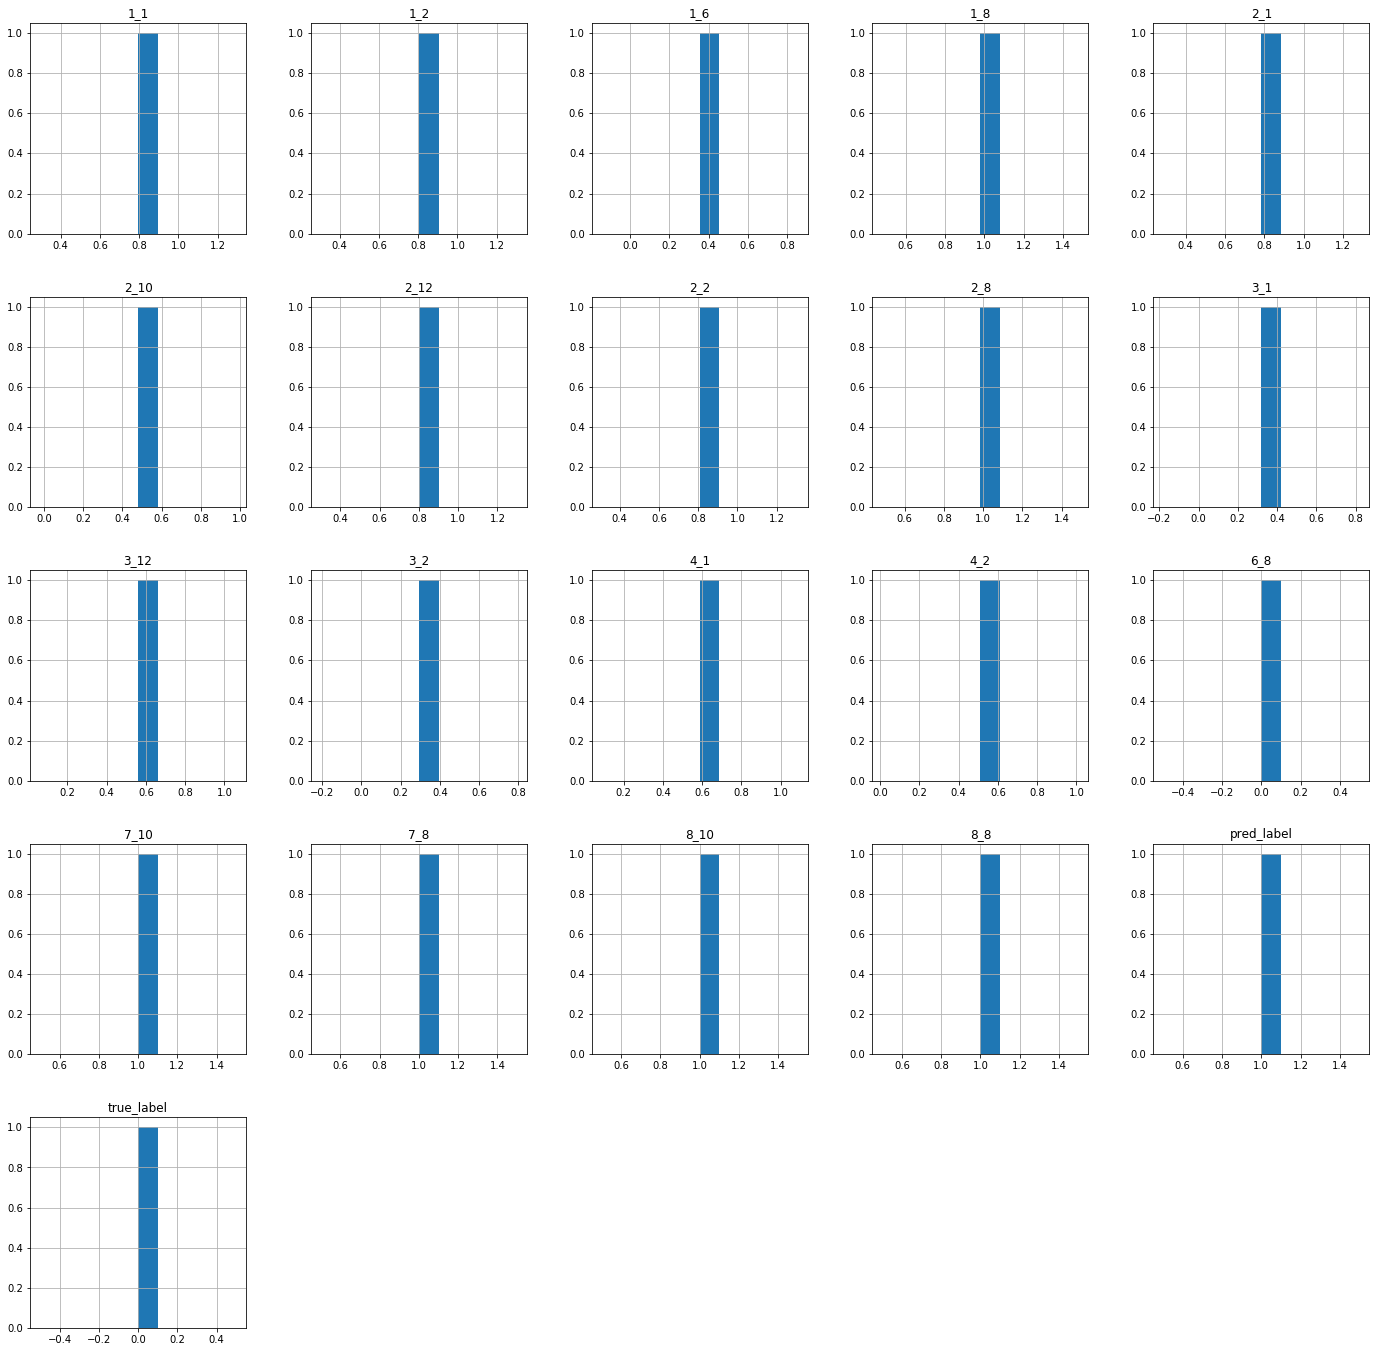

In [65]:
print_hist_models_predictions_fp(df_fp)

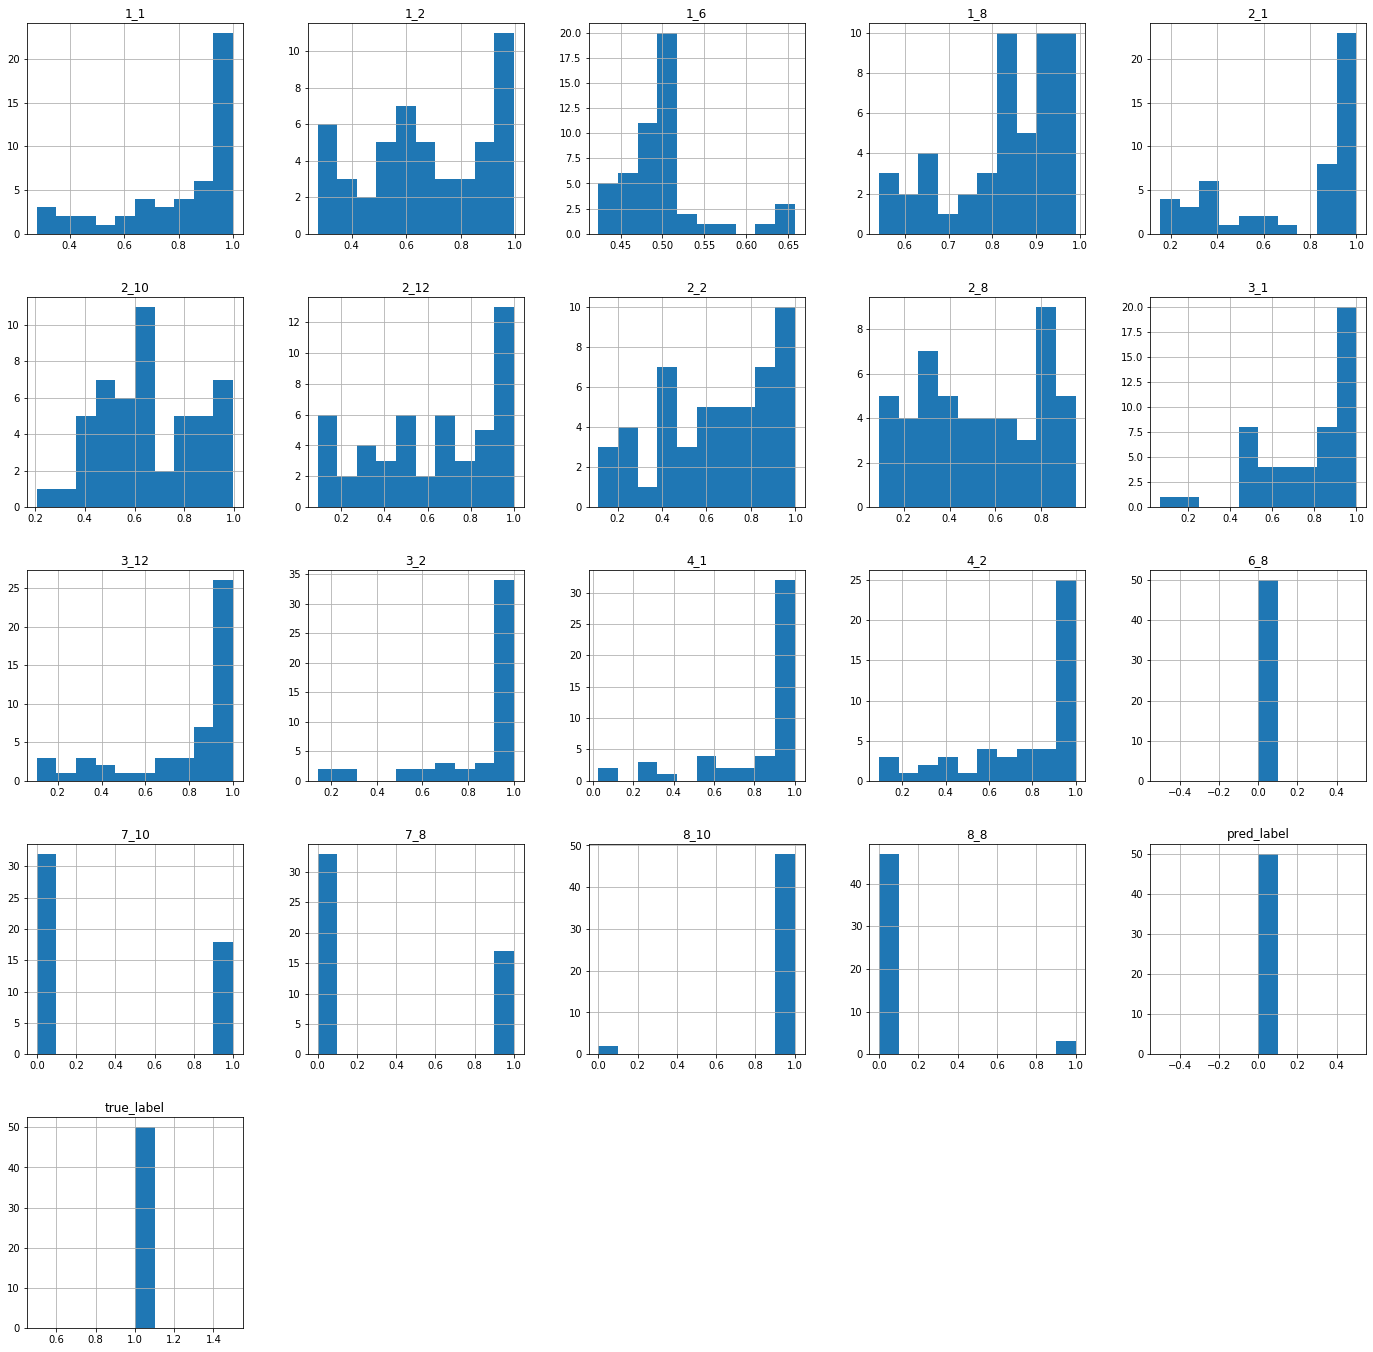

In [66]:
print_hist_models_predictions_fn(df_fn)

In [67]:
print(classification_report(df_res.true_label, df_res.pred_label))

              precision    recall  f1-score   support

           0       0.52      0.98      0.68        56
           1       0.93      0.22      0.35        64

    accuracy                           0.57       120
   macro avg       0.73      0.60      0.52       120
weighted avg       0.74      0.57      0.51       120



In [68]:
csv_path = "/Users/helemanc/PycharmProjects/ambient-intelligence/speech_emotion_recognition/ensemble_validation_results/avg_1_validation_ravdess_0_7.csv"
df_res.to_csv(csv_path)

# Validation - CREMA

We use the same code of the main.py of the real application, without VAD module

In [70]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'calm':0,  'happy':0, 'sadness':1, 'surprise':0, 'angry':1}
labels= pd.Series(list(CREMA_test.emotion_label)).replace(emotion_enc)

In [71]:
predictions, model_prediction_list = make_predictions(CREMA_test, labels, prediction_scheme='avg_1')

  2%|▏         | 1/60 [00:15<15:30, 15.78s/it]

[0.9423936, 0.2223, 0.42800087, 0.27214968, 0.20915493, 0.9123868, 0.14258936, 0.2740359, 0.2760961, 0.097798586, 0.5353871, 0.35252604, 0.4341375, 0.2696848, 1, 1, 0, 1, 1]
True label 0 Predicted label 1


  3%|▎         | 2/60 [00:40<17:48, 18.41s/it]

[0.00010746527, 0.012660742, 0.07294172, 0.00037914515, 0.052348763, 0.014881283, 0.9806503, 7.371937e-06, 0.9244281, 0.94311064, 0.00076302886, 0.89527696, 0.357527, 0.017751694, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


  5%|▌         | 3/60 [00:56<16:56, 17.83s/it]

[0.9204529, 0.05272153, 0.44572386, 0.04823491, 0.17024133, 0.9746159, 0.9986675, 0.2599432, 0.906368, 0.9543266, 0.3862216, 0.9772721, 0.40682077, 0.08410403, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


  7%|▋         | 4/60 [01:11<15:39, 16.78s/it]

[0.66478425, 0.0981316, 0.5327675, 0.06745085, 0.35538435, 0.9262799, 0.93717015, 0.030112714, 0.9962518, 0.8791234, 0.9204557, 0.9655038, 0.43116713, 0.2710281, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


  8%|▊         | 5/60 [01:24<14:21, 15.66s/it]

[0.94114673, 0.8019742, 0.67143726, 0.08993423, 0.4423831, 0.9934374, 0.7888447, 0.9892617, 0.49283904, 0.34045875, 0.2448155, 0.7783722, 0.4319266, 0.48727322, 0, 1, 0, 1, 1]
True label 1 Predicted label 0


 10%|█         | 6/60 [01:34<12:39, 14.07s/it]

[0.98710865, 0.9988915, 0.6645959, 0.08705899, 0.7664153, 0.99762, 0.9945264, 0.99610305, 0.9473134, 0.93795514, 0.19847465, 0.97056973, 0.38308042, 0.7163267, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 12%|█▏        | 7/60 [01:47<12:05, 13.69s/it]

[0.73487836, 0.20819455, 0.7435874, 0.017233789, 0.33793306, 0.6149646, 0.9953268, 0.43511462, 0.9815142, 0.97728646, 0.27315235, 0.81664634, 0.45160174, 0.06959051, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 13%|█▎        | 8/60 [02:01<12:02, 13.89s/it]

[0.13647828, 0.5058113, 0.44694823, 0.05605495, 0.34686047, 0.49994862, 0.9926307, 0.008024693, 0.9977236, 0.97151756, 0.6775913, 0.99546784, 0.4697503, 0.3812838, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 15%|█▌        | 9/60 [02:15<11:52, 13.96s/it]

[0.008713037, 0.12106031, 0.40253437, 0.008222461, 0.17432883, 0.08613974, 0.9954494, 0.00088346004, 0.9955689, 0.92226124, 0.0035957396, 0.9938067, 0.3981528, 0.07433069, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 17%|█▋        | 10/60 [02:26<10:44, 12.90s/it]

[0.43848395, 0.280414, 0.45259595, 0.17053196, 0.36454237, 0.37115744, 0.06518367, 0.11188972, 0.10811418, 0.19664073, 0.35783285, 0.23275483, 0.5186649, 0.51604474, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 18%|█▊        | 11/60 [02:35<09:42, 11.88s/it]

[0.025942892, 0.47900182, 0.27623248, 0.009105325, 0.28533748, 0.65996575, 0.9148432, 0.003912598, 0.9615699, 0.8458456, 0.077608615, 0.93100214, 0.39129466, 0.119247496, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 20%|██        | 12/60 [02:44<08:49, 11.03s/it]

[0.9580912, 0.9368119, 0.6507692, 0.047074646, 0.37576038, 0.9999511, 0.99728966, 0.99208826, 0.9730621, 0.86611027, 0.89612067, 0.9436343, 0.37282956, 0.43765393, 0, 1, 0, 0, 1]
True label 1 Predicted label 0


 22%|██▏       | 13/60 [02:54<08:12, 10.48s/it]

[0.09704712, 0.569112, 0.542054, 0.015521973, 0.5132216, 0.24013728, 0.12882447, 0.033746183, 0.26499033, 0.3488229, 0.0022812486, 0.37077963, 0.3098389, 0.47533756, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 23%|██▎       | 14/60 [03:04<07:57, 10.37s/it]

[0.9999716, 0.9958572, 0.87263364, 0.09640914, 0.96901035, 0.99983656, 0.9999911, 0.99954367, 0.99387705, 0.99817663, 0.93377465, 0.9988897, 0.33856946, 0.9572027, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 25%|██▌       | 15/60 [03:17<08:27, 11.27s/it]

[0.0010431409, 0.0691351, 0.031692564, 0.00037547946, 0.13671124, 0.19420823, 0.5960735, 0.00019925833, 0.9670231, 0.6045213, 0.06589031, 0.8647139, 0.3263378, 0.026157975, 1, 0, 1, 0, 1]
True label 1 Predicted label 0


 27%|██▋       | 16/60 [03:30<08:37, 11.76s/it]

[0.52871495, 0.24054575, 0.6527388, 0.13025281, 0.44799393, 0.53965336, 0.074478835, 0.14652115, 0.008578032, 0.15365121, 0.36751527, 0.13231933, 0.4077342, 0.88973165, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 28%|██▊       | 17/60 [03:43<08:45, 12.21s/it]

[0.30051175, 0.8314997, 0.49653763, 0.108159155, 0.53718114, 0.56739527, 0.12674227, 0.5575559, 0.34745312, 0.1774854, 0.13413417, 0.2155256, 0.37833315, 0.5179865, 1, 1, 0, 1, 1]
True label 0 Predicted label 1


 30%|███       | 18/60 [04:03<10:06, 14.43s/it]

[0.0148380995, 0.17693827, 0.34163278, 0.005879551, 0.14732066, 0.20202777, 0.4190024, 0.0030131042, 0.8992876, 0.41914278, 0.001819104, 0.59093267, 0.43949172, 0.07019696, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 32%|███▏      | 19/60 [04:14<09:07, 13.36s/it]

[0.9976381, 0.17912036, 0.8961372, 0.042372197, 0.20403999, 0.9044644, 0.9997413, 0.8031353, 0.9866731, 0.9785346, 0.8500788, 0.9961022, 0.4782951, 0.18589497, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 33%|███▎      | 20/60 [04:25<08:34, 12.85s/it]

[0.051805258, 0.2865026, 0.3420432, 0.0056904256, 0.41672587, 0.16788161, 0.9909239, 0.0050342977, 0.97450656, 0.92591226, 0.12258589, 0.99264956, 0.36594445, 0.16263843, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 35%|███▌      | 21/60 [04:37<08:02, 12.36s/it]

[0.99996936, 0.63263243, 0.53012383, 0.05185464, 0.290183, 0.9954602, 0.9999378, 0.98555666, 0.9997666, 0.9845551, 0.5539068, 0.99479747, 0.3736738, 0.37649116, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 37%|███▋      | 22/60 [04:45<07:09, 11.31s/it]

[0.11894971, 0.18732187, 0.3581639, 0.013250411, 0.1110208, 0.5673634, 0.9661783, 0.0062309206, 0.98705035, 0.8995284, 0.12826627, 0.98567295, 0.45377612, 0.076084375, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 38%|███▊      | 23/60 [05:00<07:29, 12.16s/it]

[0.16885674, 0.12965599, 0.4343359, 0.05817744, 0.34487134, 0.4394217, 0.4177443, 0.054169804, 0.9242564, 0.25750643, 0.14704382, 0.671119, 0.4700449, 0.41924408, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 40%|████      | 24/60 [05:12<07:24, 12.35s/it]

[0.96561563, 0.9794159, 0.4074244, 0.018340468, 0.15284029, 0.9661741, 0.9925252, 0.86099637, 0.8125044, 0.9002486, 0.017428994, 0.86147594, 0.34582976, 0.08095375, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 42%|████▏     | 25/60 [05:26<07:25, 12.72s/it]

[0.021888703, 0.04404983, 0.16883028, 0.0018168688, 0.095291525, 0.520742, 0.9834496, 9.9039986e-05, 0.99002296, 0.958661, 0.08127996, 0.97851217, 0.3683594, 0.0087400675, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 43%|████▎     | 26/60 [05:37<06:57, 12.27s/it]

[0.87343204, 0.5588426, 0.58550906, 0.16433528, 0.410596, 0.97855973, 0.72745204, 0.9274901, 0.85458314, 0.67436016, 0.9206325, 0.7501223, 0.4546432, 0.3416115, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 45%|████▌     | 27/60 [05:47<06:25, 11.68s/it]

[0.6248449, 0.895154, 0.49672207, 0.014424741, 0.6870376, 0.67607605, 0.7414133, 0.16899642, 0.48419917, 0.53743386, 0.008789271, 0.26636818, 0.35747963, 0.36124134, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 47%|████▋     | 28/60 [05:58<06:03, 11.35s/it]

[0.2451337, 0.9353132, 0.41445604, 0.0046537817, 0.94793785, 0.53016955, 0.59359705, 0.027154565, 0.99720025, 0.8491918, 0.3830573, 0.84932613, 0.28314495, 0.7555462, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 48%|████▊     | 29/60 [06:11<06:10, 11.95s/it]

[0.22646624, 0.37481523, 0.36877447, 0.00952965, 0.19364598, 0.7766501, 0.7590626, 0.016100109, 0.87167215, 0.55511034, 0.5345672, 0.7682859, 0.3964342, 0.17976838, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 50%|█████     | 30/60 [06:24<06:05, 12.18s/it]

[0.07139239, 0.2445868, 0.50157064, 0.014131188, 0.2209884, 0.077715725, 0.96046597, 0.010026664, 0.9790772, 0.9180906, 0.0034497976, 0.9106296, 0.4070512, 0.10216537, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 52%|█████▏    | 31/60 [06:35<05:46, 11.95s/it]

[0.9014854, 0.8326564, 0.72143495, 0.06668961, 0.3658722, 0.98764753, 0.11047453, 0.8881975, 0.2585721, 0.3004333, 0.7496806, 0.40203643, 0.39048257, 0.23626998, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 53%|█████▎    | 32/60 [06:49<05:49, 12.50s/it]

[0.8363589, 0.70359135, 0.5925779, 0.14041749, 0.7109046, 0.6825925, 0.9994995, 0.36682037, 0.997293, 0.99790835, 0.33949804, 0.9952446, 0.4376518, 0.31184864, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 55%|█████▌    | 33/60 [07:06<06:15, 13.91s/it]

[0.034303635, 0.3926384, 0.39048073, 0.004079163, 0.4369979, 0.5085666, 0.94269097, 0.014423698, 0.961796, 0.8597597, 0.012312025, 0.8745142, 0.34517038, 0.18725294, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 57%|█████▋    | 34/60 [07:21<06:05, 14.04s/it]

[0.3844163, 0.7831423, 0.5834301, 0.011085123, 0.43586114, 0.31029198, 0.98131484, 0.047243893, 0.9785584, 0.99139214, 0.032156527, 0.9903719, 0.35548276, 0.6486674, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 58%|█████▊    | 35/60 [07:34<05:47, 13.92s/it]

[0.18035227, 0.2635918, 0.83016694, 0.008827418, 0.36876333, 0.56410736, 0.9976928, 0.18934134, 0.99979496, 0.9505757, 0.81084037, 0.9821557, 0.35858667, 0.37917757, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 60%|██████    | 36/60 [07:44<05:05, 12.72s/it]

[0.08423877, 0.1316647, 0.17788294, 0.00057575107, 0.12041533, 0.5469398, 0.34935844, 0.01120761, 0.08610344, 0.46324337, 0.0016196668, 0.28048244, 0.4127292, 0.01380384, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 62%|██████▏   | 37/60 [07:54<04:34, 11.93s/it]

[0.01559937, 0.30012476, 0.44225016, 0.0764299, 0.35826114, 0.20478556, 0.9361311, 0.015861034, 0.83126295, 0.7993011, 0.035654604, 0.91921604, 0.411421, 0.34253675, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 63%|██████▎   | 38/60 [08:08<04:31, 12.34s/it]

[0.3825449, 0.5672389, 0.61966693, 0.076076716, 0.5355645, 0.70161945, 0.09803009, 0.3107984, 0.1301328, 0.09110126, 0.62368464, 0.18144315, 0.45052078, 0.5847947, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 65%|██████▌   | 39/60 [08:20<04:19, 12.34s/it]

[0.94653344, 0.8280062, 0.6667571, 0.333089, 0.8468275, 0.3772278, 0.99694633, 0.05575034, 0.9933393, 0.98708, 0.86639607, 0.99610937, 0.5036338, 0.9192238, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 67%|██████▋   | 40/60 [08:31<03:56, 11.81s/it]

[0.08221993, 0.30752784, 0.4412338, 0.03424731, 0.2510393, 0.17407766, 0.95971406, 0.033789694, 0.7918813, 0.7958759, 0.039695114, 0.8705052, 0.456372, 0.16274166, 1, 0, 1, 0, 1]
True label 1 Predicted label 0


 68%|██████▊   | 41/60 [08:40<03:29, 11.03s/it]

[0.9999362, 0.9989336, 0.5438496, 0.17366806, 0.6842048, 0.9999993, 0.9880018, 0.99978673, 0.969105, 0.8710301, 0.99599004, 0.8682381, 0.3822496, 0.5946232, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 70%|███████   | 42/60 [08:52<03:24, 11.38s/it]

[0.99085355, 0.9612436, 0.9732386, 0.28479677, 0.67650187, 0.8758513, 0.9965043, 0.8239782, 0.9933387, 0.96124625, 0.95364594, 0.9904231, 0.42727104, 0.843217, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 72%|███████▏  | 43/60 [09:06<03:26, 12.15s/it]

[0.8117846, 0.14125422, 0.2882126, 0.005339533, 0.06628081, 0.2804909, 0.99972373, 0.1831389, 0.7686322, 0.9959141, 0.17641234, 0.91542494, 0.3763915, 0.016585767, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 73%|███████▎  | 44/60 [09:19<03:18, 12.43s/it]

[0.0009809136, 0.06303212, 0.20641926, 0.00255996, 0.09514645, 0.012887597, 0.9782324, 0.0025285482, 0.9048368, 0.7291245, 0.0036976337, 0.82252705, 0.3397388, 0.042057186, 1, 0, 1, 0, 1]
True label 1 Predicted label 0


 75%|███████▌  | 45/60 [09:29<02:54, 11.65s/it]

[0.0025042892, 0.032871783, 0.25306386, 0.0036396086, 0.07496163, 0.033248812, 0.9503161, 0.00017637014, 0.93892395, 0.94462204, 0.03061518, 0.74346757, 0.2466596, 0.06958583, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 77%|███████▋  | 46/60 [09:39<02:37, 11.22s/it]

[0.41909063, 0.09570038, 0.32333338, 0.07134724, 0.052467525, 0.3006163, 0.7165086, 0.10036352, 0.92617583, 0.7006, 0.23955894, 0.82406676, 0.46716017, 0.21808535, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 78%|███████▊  | 47/60 [09:50<02:24, 11.14s/it]

[0.06342262, 0.12563297, 0.45120382, 0.021641105, 0.30058858, 0.39522964, 0.94037056, 0.014040202, 0.91972804, 0.8727281, 0.15768635, 0.79239047, 0.4608542, 0.0656825, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 80%|████████  | 48/60 [10:01<02:14, 11.19s/it]

[0.4614798, 0.5595149, 0.61810523, 0.043521762, 0.6737676, 0.9502096, 0.999152, 0.1686458, 0.9989525, 0.99895835, 0.97276115, 0.99659646, 0.5077694, 0.40997118, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 82%|████████▏ | 49/60 [10:12<02:01, 11.04s/it]

[0.999303, 0.99450636, 0.79185045, 0.86536276, 0.9760945, 0.9985807, 0.9893887, 0.99837244, 0.9997841, 0.9804189, 0.9926807, 0.9600198, 0.4560415, 0.99062693, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 83%|████████▎ | 50/60 [10:23<01:49, 10.95s/it]

[0.0017108023, 0.10320926, 0.40495974, 0.0070316494, 0.13793853, 0.08415583, 0.9889251, 0.0012013316, 0.9705584, 0.8549052, 0.01260826, 0.8954489, 0.42561966, 0.16377711, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 85%|████████▌ | 51/60 [10:34<01:38, 10.98s/it]

[0.0012333393, 0.046342403, 0.22554272, 0.0069114566, 0.130131, 0.15008774, 0.16437665, 0.00022768974, 0.45260936, 0.29969072, 0.006046295, 0.2377207, 0.36268315, 0.035740763, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 87%|████████▋ | 52/60 [10:45<01:28, 11.03s/it]

[0.1789526, 0.35263732, 0.5466447, 0.07429564, 0.42358294, 0.059484303, 0.99305916, 0.04193023, 0.9703003, 0.9757965, 0.041116387, 0.98100317, 0.44903144, 0.44104746, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 88%|████████▊ | 53/60 [10:56<01:16, 10.86s/it]

[0.81250036, 0.8282109, 0.49637762, 0.20525858, 0.5173014, 0.9889997, 0.046506792, 0.7444981, 0.06516537, 0.123885036, 0.90768796, 0.18338716, 0.41474238, 0.25084215, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 90%|█████████ | 54/60 [11:07<01:06, 11.06s/it]

[0.014864475, 0.12784511, 0.4251004, 0.008235037, 0.15584263, 0.035899848, 0.99513614, 0.0065169632, 0.9678956, 0.93822, 0.0016286075, 0.9818412, 0.35271448, 0.0346978, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 92%|█████████▏| 55/60 [11:17<00:54, 10.85s/it]

[0.9799402, 0.5566182, 0.43337134, 0.027550519, 0.48786995, 0.90431523, 0.0035302937, 0.27085322, 0.030516624, 0.056644857, 0.9330989, 0.04693657, 0.43550095, 0.12064761, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 93%|█████████▎| 56/60 [11:27<00:42, 10.51s/it]

[0.96569777, 0.91925275, 0.43818694, 0.14708269, 0.91229725, 0.9320173, 0.9994161, 0.9268411, 0.9998217, 0.99884474, 0.93052506, 0.9990894, 0.4122315, 0.9275408, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 95%|█████████▌| 57/60 [11:38<00:31, 10.63s/it]

[0.18262309, 0.0791266, 0.285273, 0.021894991, 0.21018359, 0.16371125, 0.845371, 0.008263946, 0.895239, 0.83229065, 0.043648392, 0.5502655, 0.388101, 0.11703825, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 97%|█████████▋| 58/60 [11:48<00:20, 10.49s/it]

[0.96919465, 0.5013953, 0.95213413, 0.2429367, 0.5406688, 0.967735, 0.8848463, 0.91639686, 0.9719175, 0.86430174, 0.92260325, 0.98230493, 0.47407493, 0.6965438, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 98%|█████████▊| 59/60 [11:59<00:10, 10.55s/it]

[0.0038156807, 0.14771256, 0.3256265, 0.045722812, 0.1947583, 0.029464722, 0.94739056, 0.004737884, 0.7916268, 0.83285594, 0.0008639395, 0.91061115, 0.40592176, 0.093203664, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


100%|██████████| 60/60 [12:10<00:00, 12.17s/it]

[0.86969054, 0.20193255, 0.7277348, 0.24910706, 0.39458507, 0.5265141, 0.9990241, 0.9283451, 0.9037669, 0.9634464, 0.1542789, 0.7735318, 0.46463913, 0.48720044, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


In [72]:
df_model_predictions = create_dataframe_prediction_per_model(model_prediction_list)
df_predictions = create_dataframe_predictions(predictions)
df_res = create_dataframe_res(labels, df_predictions, df_model_predictions, CREMA_test)
df_fp, df_fn = create_dataframes_false_positives_false_negatives(df_res)

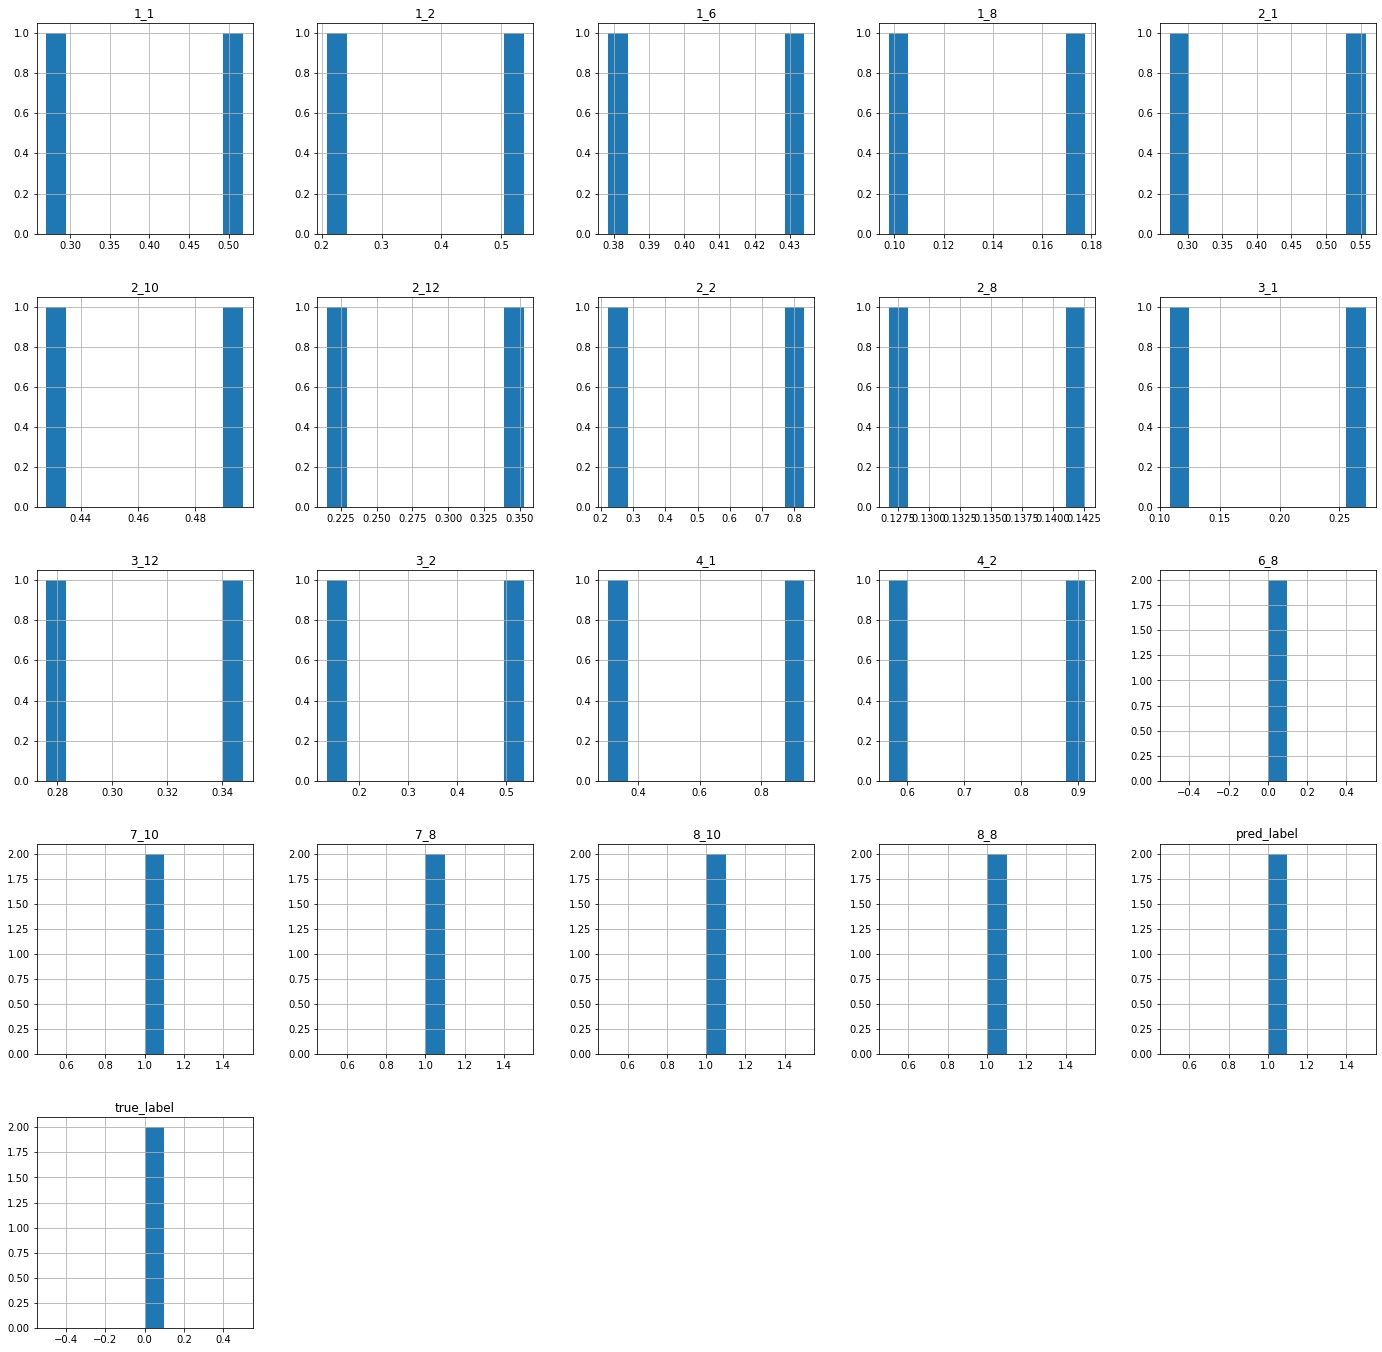

In [73]:
print_hist_models_predictions_fp(df_fp)

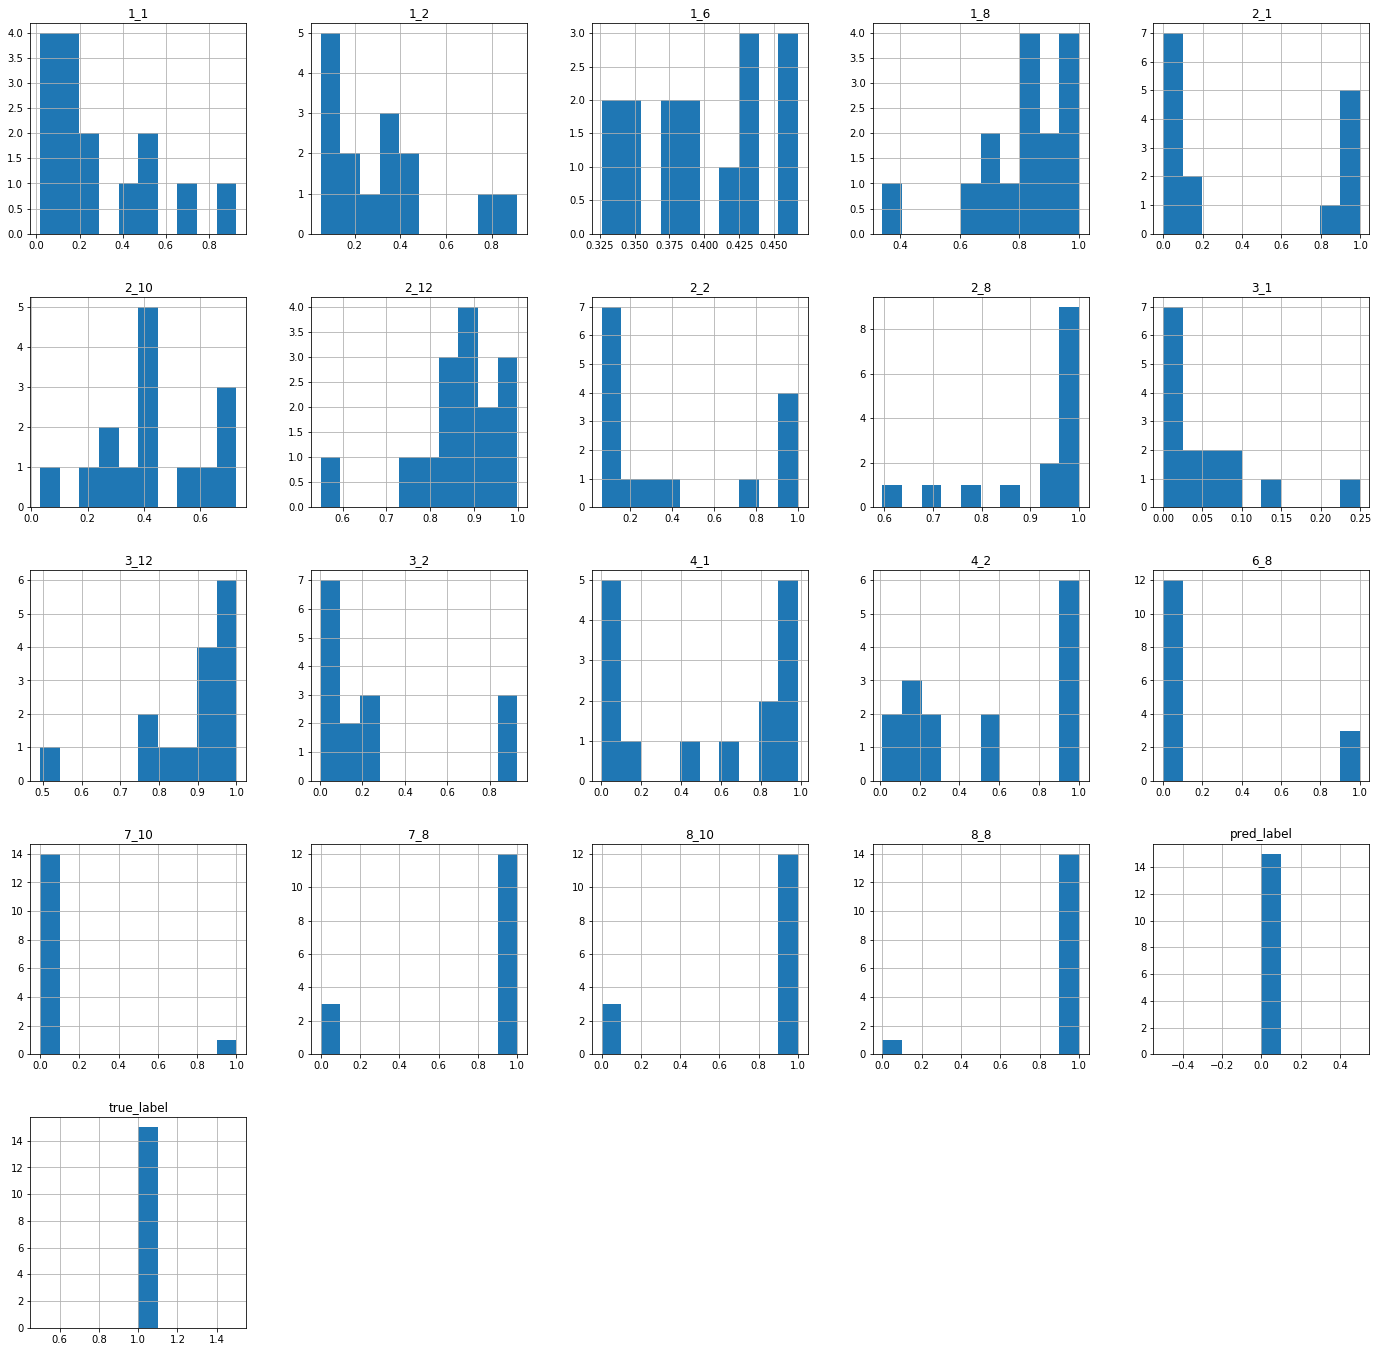

In [74]:
print_hist_models_predictions_fn(df_fn)

In [75]:
print(classification_report(df_res.true_label, df_res.pred_label))

              precision    recall  f1-score   support

           0       0.40      0.83      0.54        12
           1       0.94      0.69      0.80        48

    accuracy                           0.72        60
   macro avg       0.67      0.76      0.67        60
weighted avg       0.83      0.72      0.74        60



In [76]:
csv_path = "/Users/helemanc/PycharmProjects/ambient-intelligence/speech_emotion_recognition/ensemble_validation_results/avg_1_validation_crema_0_7.csv"
df_res.to_csv(csv_path)